In [349]:
require(data.table)
require(dada2)
require(phyloseq)
require(ggplot2)
require(RColorBrewer)
require(metacoder)
require(tidyverse)
library("DESeq2")

options(repr.plot.width=20, repr.plot.height=15)

In [350]:
meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [351]:
growth17=read.csv("~/Documents/DE/DE_16S/meta17_growth.csv")
growth18=read.csv("~/Documents/DE/DE_16S/meta18_growth.csv")

In [352]:
growth=rbind(growth17, growth18)

In [354]:
dim(meta)

[1] 274  17

In [355]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [356]:
#pull out the dilution effect samples
meta_de=meta[meta$Experiment=="Field17"|meta$Experiment=="Lab18",]

In [357]:
dim(meta_de)

[1] 213  17

In [358]:
meta_de$Volume_delta=growth$Volume_delta
meta_de$Weight_delta=growth$Weight_delta

In [359]:
asv_de=asv_all[rownames(asv_all) %in% meta_de$UniqueID,]

In [360]:
asv_de=asv_de[rowSums(asv_de)>10000,]

In [361]:
asv_de=asv_de[,colSums(asv_de)>0]

In [362]:
taxa_de=taxa[rownames(taxa)%in% colnames(asv_de),]

In [363]:
(asv_de)

TACGTAGGGGGCGAACGTTGTTCGGAATCACTGGGCGTAAAGGGTGCGCAGGCTGCTCATCAAGTCAGTTGTGAAATTTCGTGGCTCAACCACGAAGCTGCTGCTGATACTGTTGGGCTAGAGTCATAGATAGAGGTAGCGGGAATTCCTGGTGTAGGAGTGAAATCTGTAGATATCAGGAGGAACACCAAGGGTGAAGACAAGCTACTGGGTAATGACTGACGCTGAGGCACGAAAGCTAGGGGAGCAAATGGG
2017_NW_HIGH_MONO_B1_CV    2739                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_B11_CV  11391                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_B12_CV  11744                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_B14_CV 109482                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_B18_CV  19007                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P1_CV   77877                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P12_CV  15536                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P14_CV  17259                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P16_CV  29982                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P8_CV   34999                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_P9_CV   37630                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_R18_CV  31600                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_R4_CV   17267                                                                                                                                                                                                                                                         
2017_NW_HIGH_MONO_R6_CV     724                                                            

In [364]:
#for some reason the bracket subsetting was having a hard time with the NAs
taxa_de_clean=subset(taxa_de, Kingdom!="Eukaryota")
taxa_de_clean=subset(taxa_de_clean, Order!="Chloroplast"|is.na(Order))

In [365]:
table(taxa_de$Kingdom)


  Archaea  Bacteria Eukaryota 
      196     14266       163 

In [366]:
table(taxa_de_clean$Kingdom)


 Archaea Bacteria 
     196    13988 

In [367]:
taxa_de=as.matrix(taxa_de_clean)
meta_de=as.data.frame(meta_de)
row.names(meta_de)=meta_de$UniqueID

In [368]:
OTU = otu_table(t(asv_de), taxa_are_rows = TRUE)
TAX = tax_table(taxa_de)
SAMP=sample_data(meta_de)

In [369]:
#make peacrabs into a factor
SAMP$peacrabs=factor(SAMP$peacrabs)

In [370]:
#SAMP$RFTM_score=factor(SAMP$RFTM_score)

In [371]:
#make a simpler rftm factor without 0.5 and combining 4 and 5
SAMP$RFTM_simp=factor(SAMP$RFTM_score)
SAMP$RFTM_simp=sub("0.5", "1", SAMP$RFTM_simp)
SAMP$RFTM_simp=sub("5", "4", SAMP$RFTM_simp)

In [372]:
#make RFTM presence absence
SAMP$RFTM_pa=ifelse(SAMP$RFTM_score=="0", 0, 1)
SAMP$RFTM_pa=factor(SAMP$RFTM_pa)

In [373]:
table(SAMP$RFTM_pa, SAMP$Year)

   
    2017 2018
  0   34   82
  1   78   19

In [374]:
table(SAMP$peacrabs, SAMP$Year)

   
    2017 2018
  0  103    4
  1    9    0

In [375]:
#transform otu counts
OTU=transform_sample_counts(OTU, function(x) 1000000 * x/sum(x))

In [376]:
#make phyloseq object
DE = phyloseq(OTU, TAX, SAMP)

In [377]:
DE

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14184 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 14184 taxa by 6 taxonomic ranks ]

In [378]:
sample_data_clean=sample_data(DE)

In [379]:
table(sample_data_clean$Species)


 CV  IR  MB  MM 
151  30   6   5 

In [380]:
#separate 2017 and 2018
DE17=subset_samples(DE, Year=="2017")
DE18=subset_samples(DE, Year=="2018")

In [381]:
SAMP17=sample_data(DE17)

In [382]:
table(SAMP17$RFTM_score)


  0 0.5   1   2   3   4   5 
 30   9  24  16  14   4   1 

In [245]:
head(sample_data(DE17))

V1 UniqueID                 Experiment Year Site
2017_NW_HIGH_MONO_B1_CV  1  2017_NW_HIGH_MONO_B1_CV  Field17    2017 NW  
2017_NW_HIGH_MONO_B11_CV 2  2017_NW_HIGH_MONO_B11_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B12_CV 3  2017_NW_HIGH_MONO_B12_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B14_CV 4  2017_NW_HIGH_MONO_B14_CV Field17    2017 NW  
2017_NW_HIGH_MONO_B18_CV 5  2017_NW_HIGH_MONO_B18_CV Field17    2017 NW  
2017_NW_HIGH_MONO_P1_CV  6  2017_NW_HIGH_MONO_P1_CV  Field17    2017 NW  
                         Treatment1_Density Treatment2_Diversity Color_Bucket
2017_NW_HIGH_MONO_B1_CV  HIGH               MONO                 B           
2017_NW_HIGH_MONO_B11_CV HIGH               MONO                 B           
2017_NW_HIGH_MONO_B12_CV HIGH               MONO                 B           
2017_NW_HIGH_MONO_B14_CV HIGH               MONO                 B           
2017_NW_HIGH_MONO_B18_CV HIGH               MONO                 B           
2017_NW_HIGH_MONO_P1_CV  HIGH               MONO                 P           
                         Number Species ⋯ peacrabs Phase_1_DO Phase_1_temp
2017_NW_HIGH_MONO_B1_CV  1      CV      ⋯ 0                               
2017_NW_HIGH_MONO_B11_CV 11     CV      ⋯ 0                               
2017_NW_HIGH_MONO_B12_CV 12     CV      ⋯ 0                               
2017_NW_HIGH_MONO_B14_CV 14     CV      ⋯ 0                               
2017_NW_HIGH_MONO_B18_CV 18     CV      ⋯ 0                               
2017_NW_HIGH_MONO_P1_CV  1      CV      ⋯ 0                               
                         Phase_2_DO Phase_2_Temp Overall_treatment Volume_delta
2017_NW_HIGH_MONO_B1_CV                                            20.76635    
2017_NW_HIGH_MONO_B11_CV                                           15.70902    
2017_NW_HIGH_MONO_B12_CV                                           21.29662    
2017_NW_HIGH_MONO_B14_CV                                           20.48726    
2017_NW_HIGH_MONO_B18_CV                                           23.90245    
2017_NW_HIGH_MONO_P1_CV                                            28.19834    
                         Weight_delta RFTM_simp RFTM_pa
2017_NW_HIGH_MONO_B1_CV  27.47500     1         1      
2017_NW_HIGH_MONO_B11_CV 13.81379     2         1      
2017_NW_HIGH_MONO_B12_CV 17.84921     0         0      
2017_NW_HIGH_MONO_B14_CV 26.56000     1         1      
2017_NW_HIGH_MONO_B18_CV 19.47239     4         1      
2017_NW_HIGH_MONO_P1_CV  30.78704     1         1

## significant OTUs presence absence of perkinsus and peacrabs

In [383]:
dds_rftmxpeasite <- phyloseq_to_deseq2(DE17, ~ RFTM_pa * peacrabs + Site)
dds_rftmxpeasite <- DESeq(dds_rftmxpeasite, test="Wald", fitType="parametric")
resultsNames(dds_rftmxpeasite)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7350 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"          "RFTM_pa_1_vs_0"     "peacrabs_1_vs_0"   
[4] "Site_OY_vs_NW"      "Site_SW_vs_NW"      "RFTM_pa1.peacrabs1"

## perkinsus presence absence

In [384]:
respa = results(dds_rftmxpeasite, name="RFTM_pa_1_vs_0")
alpha = 0.05
sigpa = respa[which(respa$padj < alpha), ]
sigpa = cbind(as(sigpa, "data.frame"), as(tax_table(DE17)[rownames(sigpa), ], "matrix"))

In [385]:
sigPA_RFTM_tax3=sigpa[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigPA_RFTM_tax3 <- as.matrix(sigPA_RFTM_tax3)


In [386]:
##turn into phyloseq object
sigPATAX <- tax_table(sigPA_RFTM_tax3)
F3_RFTMPA_wlog <- DE17
tax_table(F3_RFTMPA_wlog)=sigPATAX

In [387]:
##filter for asvs found in 1/3 of samples
F3_RFTMPA_wlog_filter <- genefilter_sample(F3_RFTMPA_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(F3_RFTMPA_wlog))
F3_RFTMPA_wlog_prune <- prune_taxa(F3_RFTMPA_wlog_filter, F3_RFTMPA_wlog)

In [388]:
F3_RFTMPA_prune=F3_RFTMPA_wlog_prune
tax_table(F3_RFTMPA_prune) <- tax_table(F3_RFTMPA_prune)[,2:7]
taxmapRFTMPA <- parse_phyloseq(F3_RFTMPA_prune)

The following 3 of 11 (27.3%) input indexes have `NA` in their classifications:
   4, 5, 7




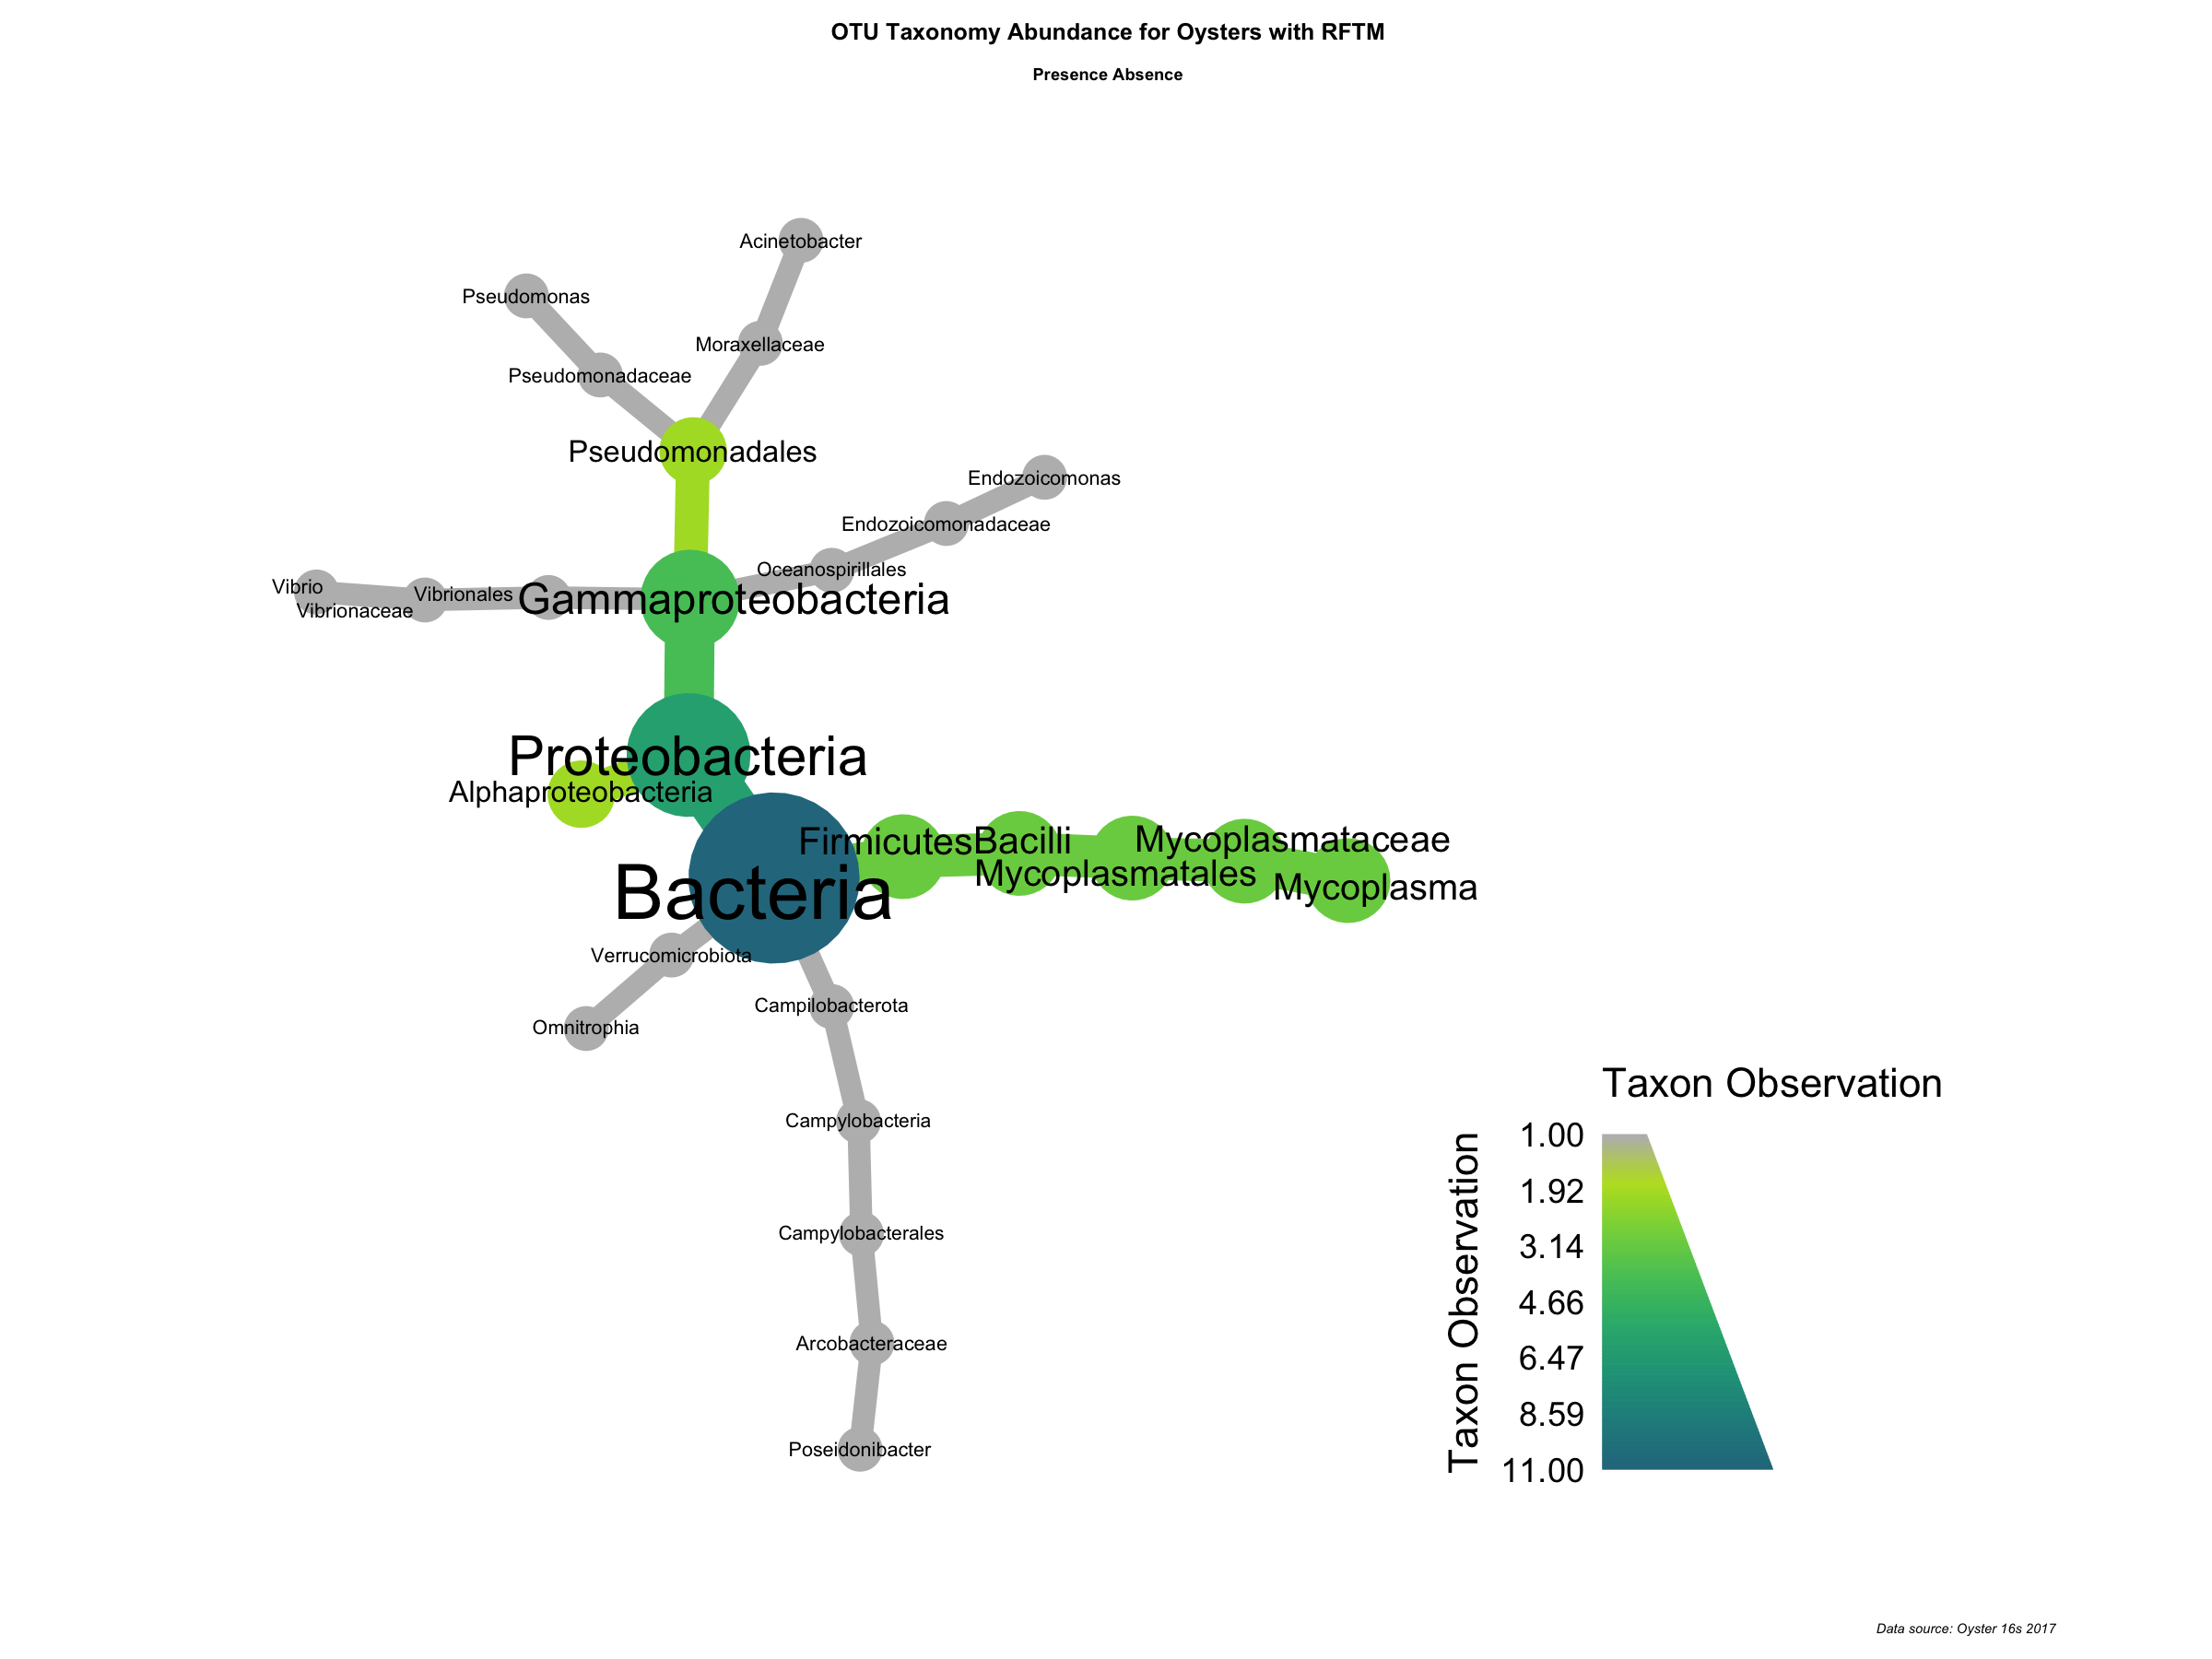

In [389]:
taxmapRFTMPA %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapRFTMPA),
            node_color = n_obs(taxmapRFTMPA),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())+
  labs(title = "OTU Taxonomy Abundance for Oysters with RFTM", 
       subtitle = "Presence Absence",
       caption = "Data source: Oyster 16s 2017")

In [390]:
PALog=as.data.frame(tax_table(F3_RFTMPA_wlog_prune))
for (i in colnames(PALog)[2:NCOL(PALog)]){
  PALog[[i]] <- (str_c(i, "_", PALog[[i]]))}
PALog=as.data.frame(t(PALog))
PALog=as.data.frame(t(fill(PALog, names(PALog))))
PALog$OTU=row.names(PALog)
PALog$log2FoldChange=as.numeric(PALog$log2FoldChange)

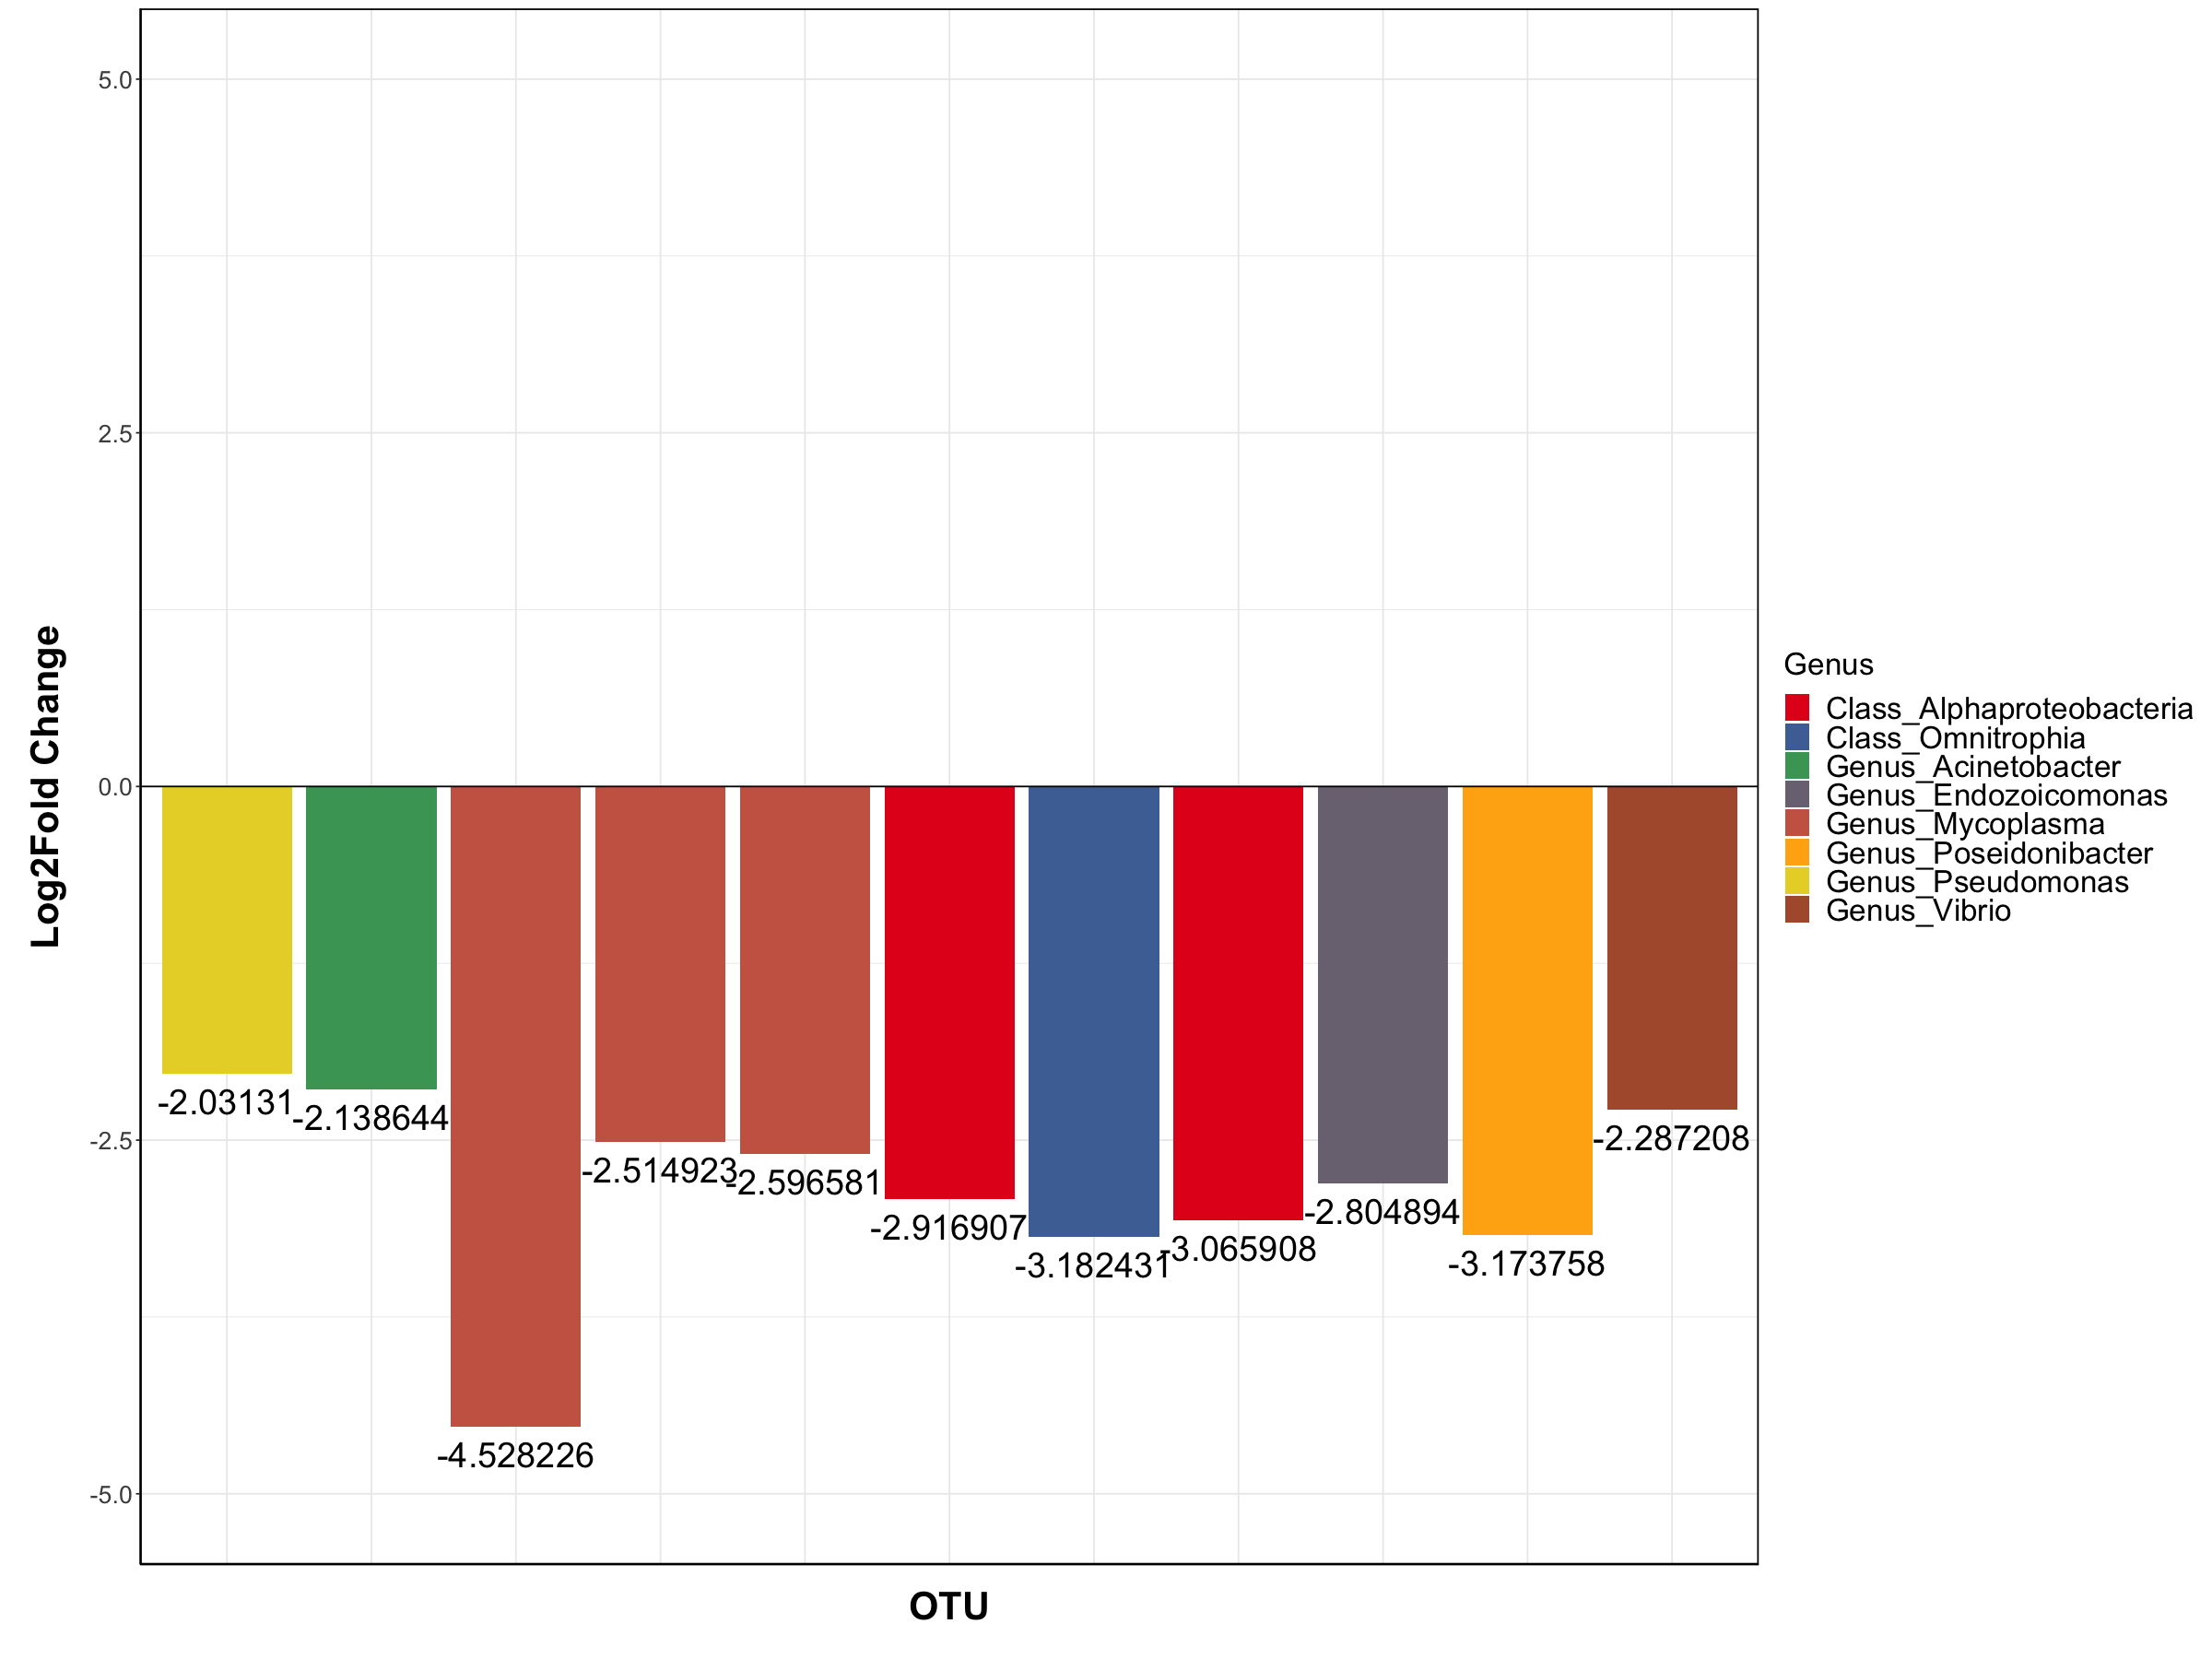

In [396]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(9)

ggplot(PALog,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-5, 5))+
  geom_hline(yintercept = 0)+
theme_bw()+
   theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [555]:
PALog$Perkinsus=PALog$log2FoldChange
PALog$log2FoldChange=NULL

In [523]:
PALog

log2FoldChange
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG  -2.514923     
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG  -2.596581     
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTTGTAAGTTTGAAGTGAAATCCAATGGCTCAACCATTGAACTGCTTTGAAAACTGCTTACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTATTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG -3.173758     
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTCTAGGTGGTTTTGTTAGTTGGATGTGAAAGCCCTCGGCTCAACCGAGGAATTGCATCCAAAACTGCATTACTAGAGTGTGAAAGGGGAAGGCGGAATTCCAAGTGTAGCGGTGAAATGCGTAGATATTTGGAGGAACACCGGTGGCGAAGGCGGCCTTCTGGTTCAACACTGACACTAAAGCGCGAAGGCTAGGGGAGCGAACAGG -3.182431     
TACGAAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGAGTACGTAGGCGGTTAGATTAGTTAGGTGTGAAATCCCGGAGCTCAACTTCGGAGTTGCACTTAATACTGTTTAACTAGAATTCAAGAGGGGAGAGTGGAATTTCCAGTGTAGGGGTGATATCCGTAGATATTGGAAGGAACATCAGAGGCGAAGGCGACTCTCTGGCTTGACATTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACAGG -2.916907     
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG -2.287208     
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGGGTACGTAGGCGGTTTAACCAGTCAGATGTGAAATCCCAGGGCTCAACCTTGGAACTGCATTTGATACTGTTAGACTAGAATCCGAGAGGGGACAGTGGAATTTCCAGTGTAGAGGTGACATCCGTAGATATTGGAAGGAACACCAGAGGCGAAGGCGACTGTCTGGATCGGTATTGACGCTGAGGTACGAAAGTGTGGGTAGCAAACAGG -3.065908     
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACGAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG -2.031310     
TACAGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGTAGGCGGCCATTTAAGTCAAATGTGAAATCCCCGAGCTTAACTTGGGAATTGCATTCGATACTGGATGGCTAGAGTATGGGAGAGGATGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCATCTGGCCTAATACTGACGCTGAGGTACGAAAGCATGGGGAGCAAACAGG -2.138644     
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTGCGTAGGCGGTTTACTAAGTCTGAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTTGGATACTGGTAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAAGAGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG  -4.528226     
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCTACTTAAGTGGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG -2.804894     
                                                                                                                                                                                                                                                              Kingdom         
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG  Kingdom_Bacteria
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG  Kingdom_Bacteria
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTTGTAAGTTTGAAGTGAAATCCAATGGCTCAACCATTGAACTGCTTTGAAAACTGCTTACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACA

In [434]:
write.csv(PALog, "~/Documents/DE/DE_16S/Oyster16S_Data23/Results/RFTM_SigOTUs.csv")

# peacrabs


In [397]:
resultsNames(dds_rftmxpeasite)

[1] "Intercept"          "RFTM_pa_1_vs_0"     "peacrabs_1_vs_0"   
[4] "Site_OY_vs_NW"      "Site_SW_vs_NW"      "RFTM_pa1.peacrabs1"

In [399]:
resPA_pea_F3 <- results(dds_rftmxpeasite, name="peacrabs_1_vs_0")
sigPA_pea_F3 <- resPA_pea_F3[which(resPA_pea_F3$padj < 0.05), ]
sigPA_pea_F3 <- cbind(as(sigPA_pea_F3, "data.frame"), as(tax_table(DE17)[rownames(sigPA_pea_F3), ], "matrix"))
sigPA_pea_F3=sigPA_pea_F3[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigPA_pea_F3 <- as.matrix(sigPA_pea_F3)

In [400]:
##turn into phyloseq object
sigPeaTAX <- tax_table(sigPA_pea_F3)
F3_Pea_wlog <- DE17
tax_table(F3_Pea_wlog)=sigPeaTAX

In [401]:
##filter for asvs found in 1/3 of samples
F3_Pea_wlog_filter <- genefilter_sample(F3_Pea_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(F3_Pea_wlog))
F3_Pea_wlog_prune <- prune_taxa(F3_Pea_wlog_filter, F3_Pea_wlog)

In [402]:
##Heattree
F3_Pea_prune=F3_Pea_wlog_prune
tax_table(F3_Pea_prune) <- tax_table(F3_Pea_prune)[,2:7]
taxmapPeaPA <- parse_phyloseq(F3_Pea_prune)

The following 4 of 17 (23.5%) input indexes have `NA` in their classifications:
   5, 7, 11, 16




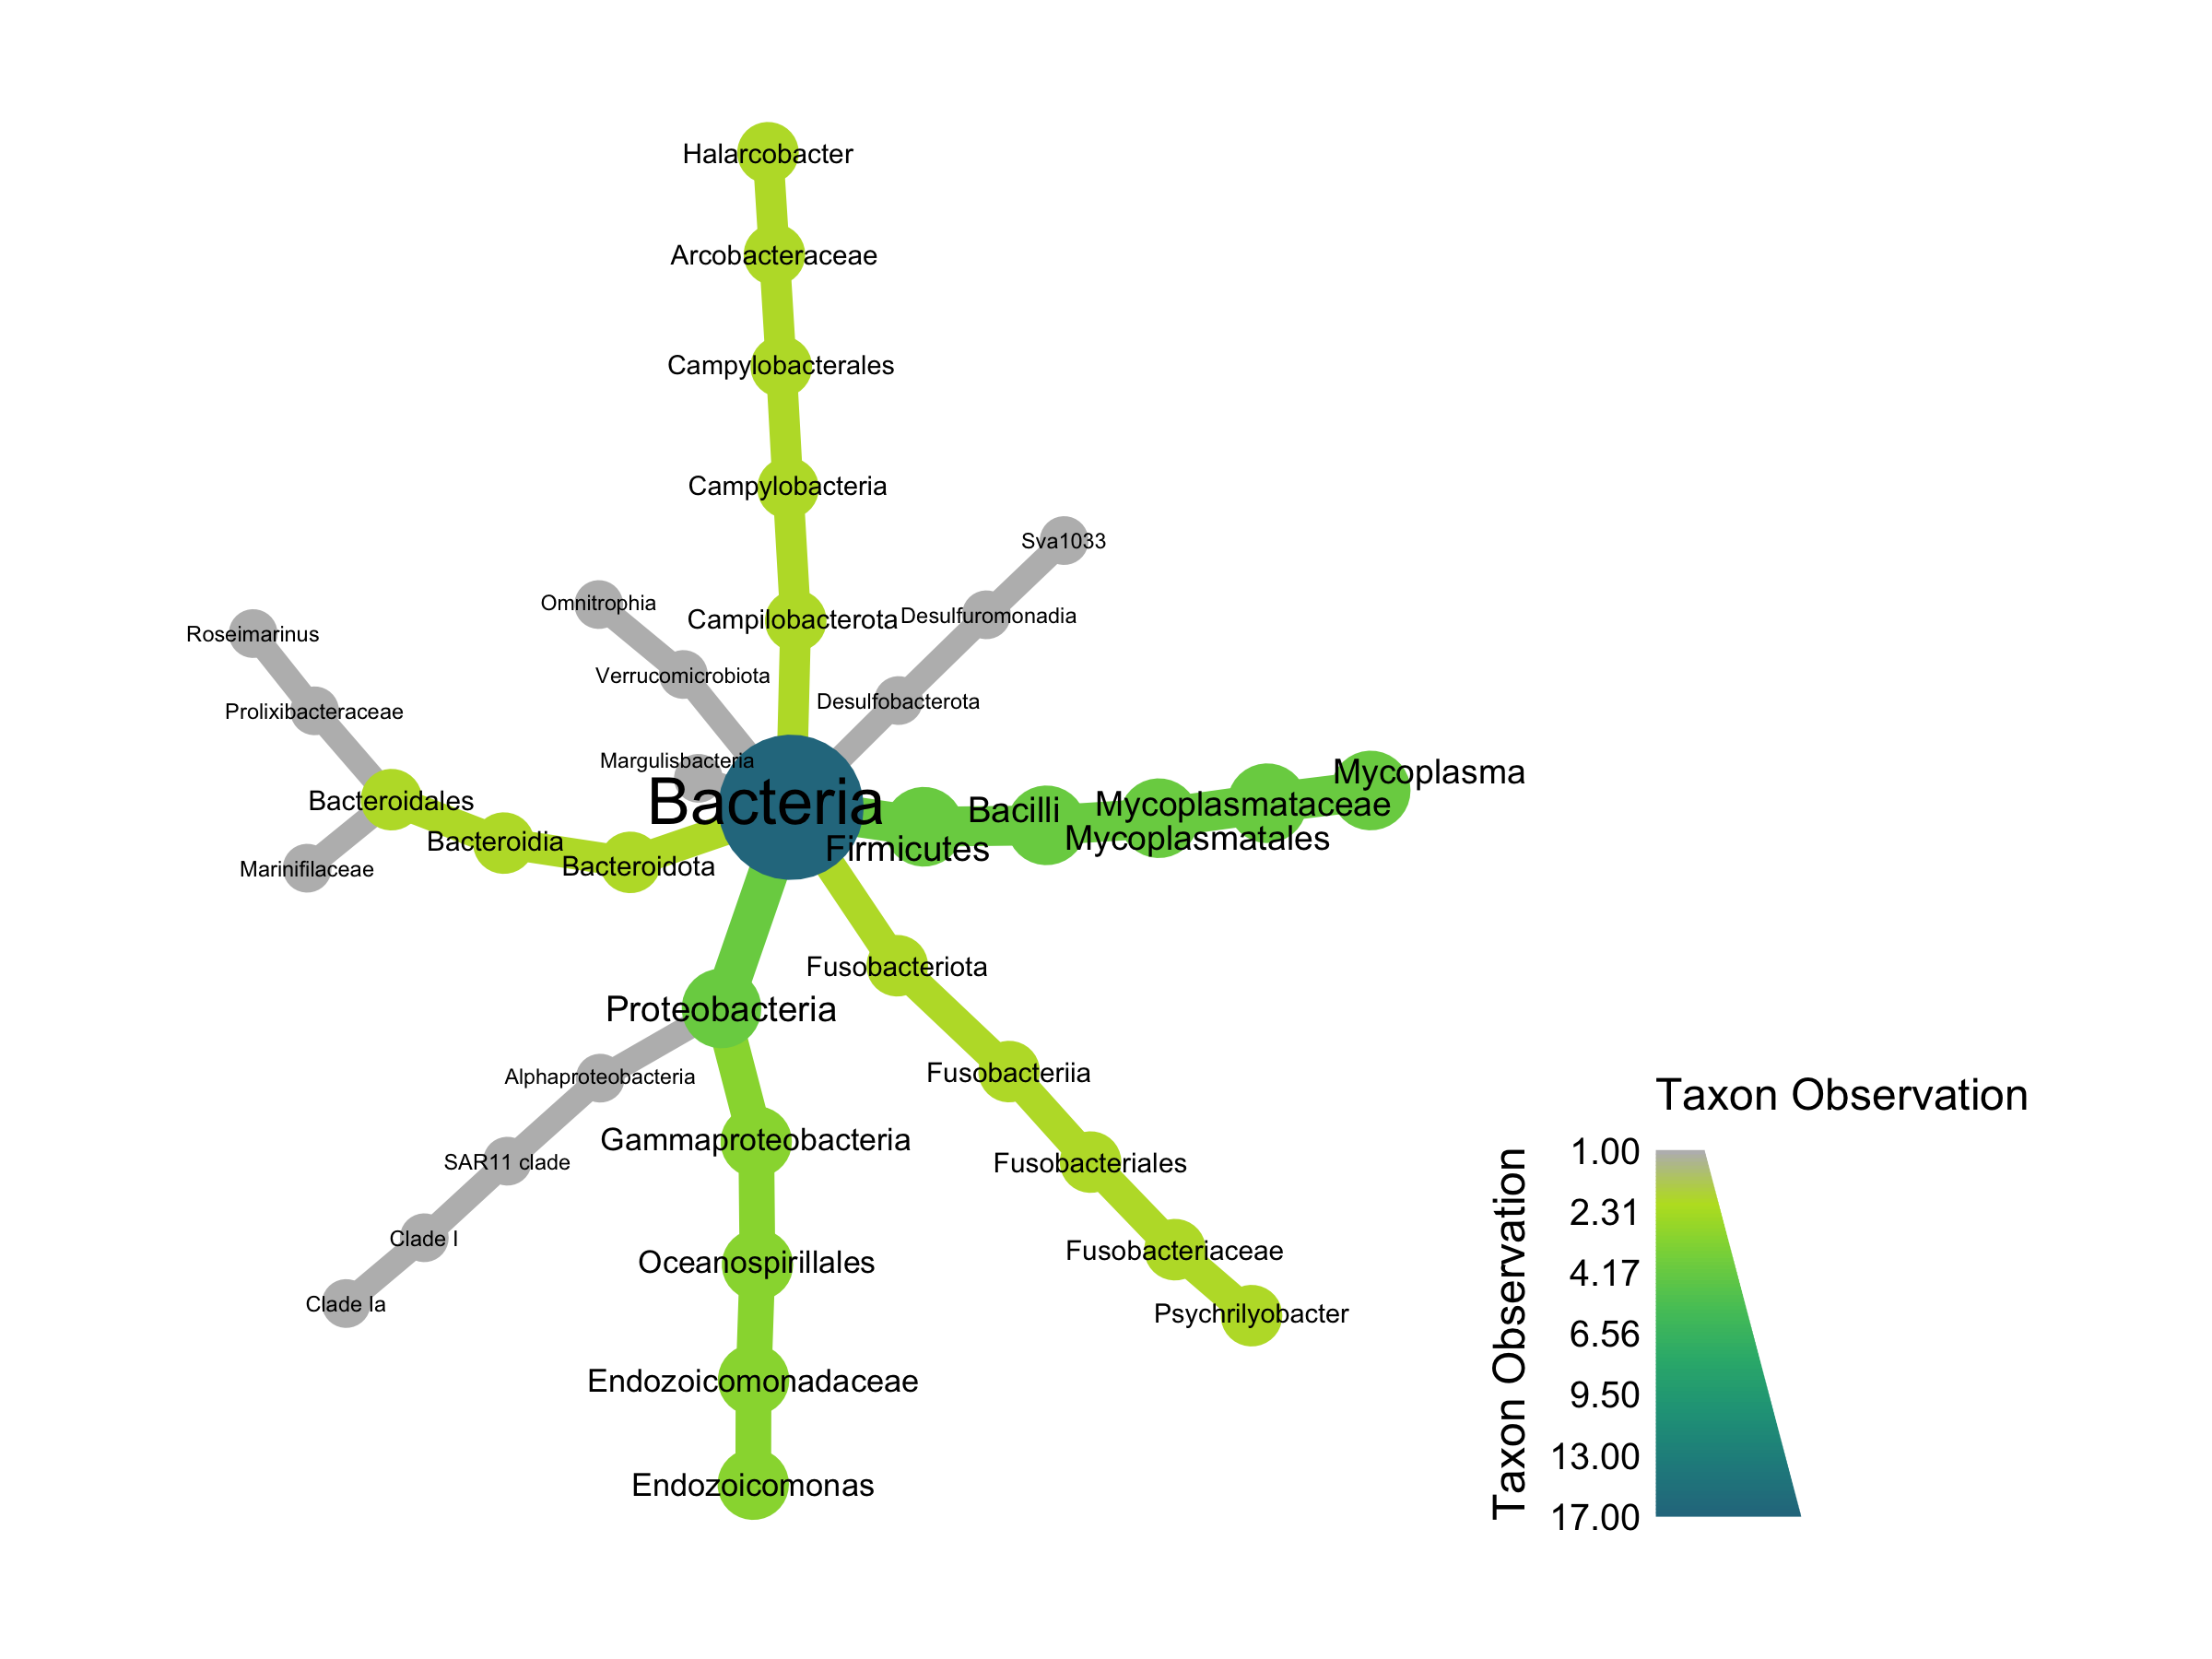

In [403]:
taxmapPeaPA %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapPeaPA),
            node_color = n_obs(taxmapPeaPA),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [406]:
##Fill in lowest taxonomic level for bargraph

PeaLog=as.data.frame(tax_table(F3_Pea_wlog_prune))
for (i in colnames(PeaLog)[2:NCOL(PeaLog)]){
  PeaLog[[i]] <- (str_c(i, "_", PeaLog[[i]]))}
PeaLog=as.data.frame(t(PeaLog))
PeaLog=as.data.frame(t(fill(PeaLog, names(PeaLog))))
PeaLog$OTU=row.names(PeaLog)
PeaLog$log2FoldChange=as.numeric(PeaLog$log2FoldChange)

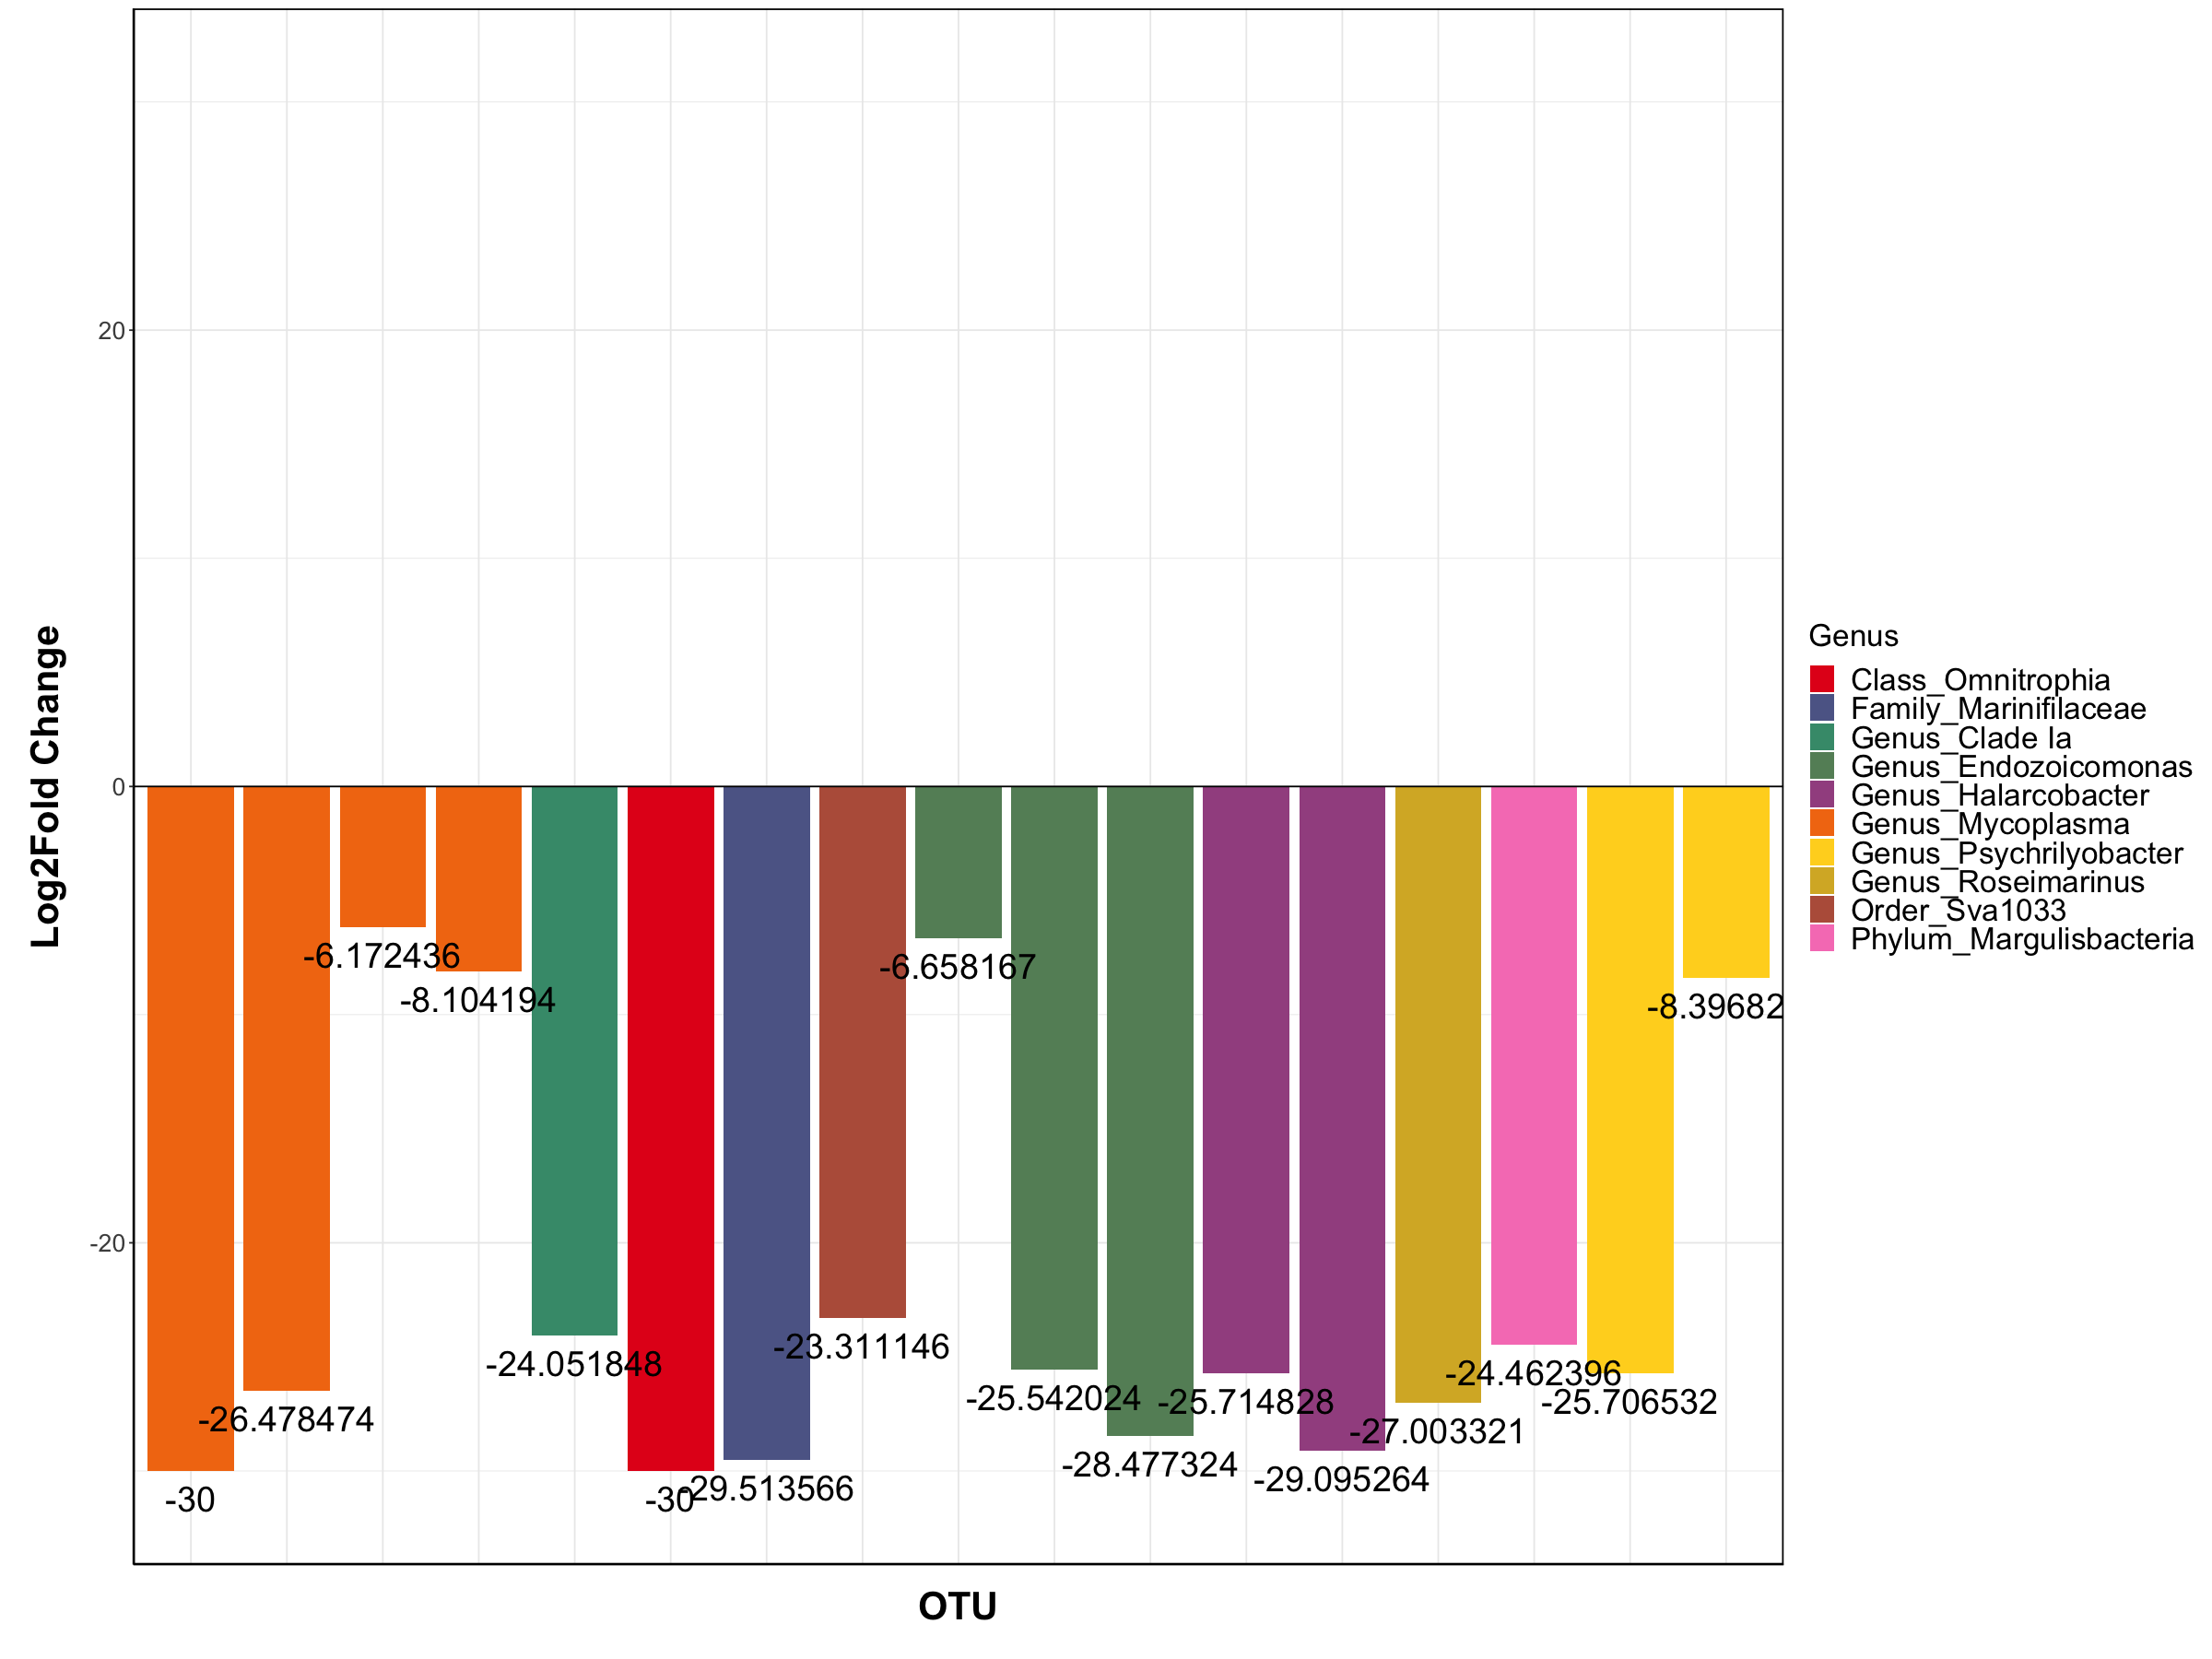

In [408]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(10)

ggplot(PeaLog,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-31, 31))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [554]:
PeaLog$Peacrab=PeaLog$log2FoldChange
PeaLog$log2FoldChange=NULL

In [433]:
write.csv(PeaLog, "~/Documents/DE/DE_16S/Oyster16S_Data23/Results/PEA_SigOTUs.csv")

## significant otus 2017 weight and volume

In [435]:
DE17w=subset_samples(DE17, !is.na(Weight_delta))

In [436]:
dds_weight17 <- phyloseq_to_deseq2(DE17w, ~ Weight_delta+Volume_delta)
dds_weight17 <- DESeq(dds_weight17, test="Wald", fitType="parametric")
resultsNames(dds_weight17)

converting counts to integer mode

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

2 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



[1] "Intercept"    "Weight_delta" "Volume_delta"

In [437]:
resweight17 <- results(dds_weight17, name="Weight_delta")
sigweight17 <- resweight17[which(resweight17$padj < 0.05), ]
sigweight17 <- cbind(as(sigweight17, "data.frame"), as(tax_table(DE17w)[rownames(sigweight17), ], "matrix"))
sigweight17=sigweight17[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight17 <- as.matrix(sigweight17)

In [438]:
##turn into phyloseq object
sigweight17TAX <- tax_table(sigweight17)
sigweight17_wlog <- DE17w
tax_table(sigweight17_wlog)=sigweight17TAX

In [439]:
sigweight17_wlog

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 165 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 165 taxa by 7 taxonomic ranks ]

In [440]:
##filter for asvs found in 1/3 of samples
sigweight17_wlog_filter <- genefilter_sample(sigweight17_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight17_wlog))
sigweight17_wlog_prune <- prune_taxa(sigweight17_wlog_filter, sigweight17_wlog)

ERROR: Error in validObject(.Object): invalid class “otu_table” object: 
 OTU abundance data must have non-zero dimensions.


In [441]:
reswvol17 <- results(dds_weight17, name="Volume_delta")
sigvol17 <- reswvol17[which(reswvol17$padj < 0.05), ]
sigvol17 <- cbind(as(sigvol17, "data.frame"), as(tax_table(DE17w)[rownames(sigvol17), ], "matrix"))
sigvol17=sigvol17[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol17 <- as.matrix(sigvol17)

In [442]:
##turn into phyloseq object
sigvol17TAX <- tax_table(sigvol17)
sigvol17_wlog <- DE17
tax_table(sigvol17_wlog)=sigvol17TAX

In [443]:
##filter for asvs found in 1/3 of samples
sigvol17_wlog_filter <- genefilter_sample(sigvol17_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol17_wlog))
sigvol17_wlog_prune <- prune_taxa(sigvol17_wlog_filter, sigvol17_wlog)

In [444]:
sigvol17_wlog_prune

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1 taxa and 98 samples ]
sample_data() Sample Data:       [ 98 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 1 taxa by 7 taxonomic ranks ]

In [529]:
CV17vol_log=as.data.frame(tax_table(sigvol17_wlog_prune))

In [553]:
CV17vol_log$CV17volume=CV17vol_log$log2FoldChange
CV17vol_log$log2FoldChange=NULL

log2FoldChange
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG  0.1584223    
                                                                                                                                                                                                                                                              Kingdom 
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Bacteria
                                                                                                                                                                                                                                                              Phylum        
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Proteobacteria
                                                                                                                                                                                                                                                              Class              
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Gammaproteobacteria
                                                                                                                                                                                                                                                              Order            
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Oceanospirillales
                                                                                                                                                                                                                                                              Family             
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Endozoicomonadaceae
                                                                                                                                                                                                                                                              Genus         
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCAATCTAAGTGGGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATCCCAAACTGGGTAGCTAGAGTACGGCAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACACTCTGGGCTGATACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG Endozoicomonas

## 2018 oysters

In [446]:
DE18CV=subset_samples(DE18, Species=="CV")

In [447]:
DE18CVw=subset_samples(DE18CV, !is.na(Weight_delta))

In [448]:
dds_weight18CV <- phyloseq_to_deseq2(DE18CVw, ~ Weight_delta+Volume_delta)
dds_weight18CV <- DESeq(dds_weight18CV, test="Wald", fitType="parametric")
resultsNames(dds_weight18CV)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"    "Weight_delta" "Volume_delta"

In [464]:
resweight18CV <- results(dds_weight18CV, name="Weight_delta")
sigweight18CV <- resweight18CV[which(resweight18CV$padj < 0.05), ]
sigweight18CV <- cbind(as(sigweight18CV, "data.frame"), as(tax_table(DE18CVw)[rownames(sigweight18CV), ], "matrix"))
sigweight18CV=sigweight18CV[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight18CV <- as.matrix(sigweight18CV)

In [450]:
##turn into phyloseq object
sigweight18CVTAX <- tax_table(sigweight18CV)
sigweight18CV_wlog <- DE18CVw
tax_table(sigweight18CV_wlog)=sigweight18CVTAX

In [596]:
sigweight18CVTAX

log2FoldChange
TACGTATGGGGCAAACGTTGTTCGGATTCACTGGGCGTAAAGAGTACGTAGGCTGTCGAGACAGTCAATGATCAAATCCCGTAGCTTAACTACGTGGTCGTTGTTGATACTACTCGACTAGAGTTTTATAGAGGTAGCGGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAGGAACACCAAAGGCGAAGGCAAGCTACTGGGTAAAAACTGACGCTGAGGTACGAAAGCCAGGGGAGCAAATGGG                                                 -7.211739    
TACGTATGTCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGAGTCTAGGCGGTTTGTTAAGTCAGATGTGAAAATGCGGGGCTCAACTCCGTATGGCCTTTGATACTGGCAAACTAGAGTACTGGAGAGGTGGGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATAGTGAAGACAGCTCACTGGACAGATACTGACGCTAAAGCTCGAAAGCGTGGGGAGCAAACAGG                                                  20.811699    
TACGTAAGGAGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGTGCGTGCAGGCTGTTTATTAAGTCTGATGTGAAAGTGCACAGCTTAACTGTGTTGTTGCGTTGGAAACTGGTAAACTAGAATTCGAGAGAGGAAATTGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAAGAACACCTGAGGCGAAAGCGAATTTCTGGCTCTGAATTGACGCTGTAGCGCGAAAGCGTAGGGAGCAAACAGG                                                -12.195112    
TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGACACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG                                                -14.608452    
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                 -18.751209    
TACGGAGGATGCAAGTGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTCTGGTAAGTCAGAGGTGAAAGACGGTGGCTCAACCATCGCAGTGCCCTTGATACTATTGGACTAGATTACATTGGAAGTAGGCGGAATGTGCGGTGTAGCGGTGAAATGCGCAGATATCGCACGGAACACCAATAGCGAAAGCAGCTTACTATACTGTTAATGACACTGAGGCACGAAAGCGTGGGTAGCAAATAGG                                                  4.555781    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGATTATTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTATTAGTCTAGAGTCCGGGAGAGGTGAGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                                                 -5.282971    
TACGTAAGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCATGTAGGTGGTAAGATAAGCTTGGAGTAAAAGACCGCAGCTCAACTGCGGAGAGCGTTGAGAACTGTCTTACTAGAGTCTAGGAGAGGAAGCTGGAATTCTTGGAGGAGGGGTGAAATCTGTAGATCCCAAGGAGAACACCAGAGGCGAAGGCGAGCTTCTGGCCATAGACTGACACTGAGATGCGAAAGCGTGGGTAGCGAACAGG                                                   9.951292    
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTCGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                 -12.206167    
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTAGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG  19.696626    
TACGGAGGGGGCGAGCGTTATTCGGATTTACTGGGCGTAAAGGGTGTGTAGGCGGCATAGTAAGTTAGTAGTGAAATCCCAGGGCTTAACCCTGGAACTGCTGCTAAAACTGCTAAGCTAGAGTTAGGTAGAGGGTAGTAGAATTTCTAGTGTAGGGGTGATATCCGTAGATATTAGAAGGAATGCCAGAGGCGAAGGCGACTACCTGGAACTATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                                -15.218839    
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCCTTAAAAGTCAGATGTGAAATCCCCGAGCTCAACTTGGGAACTGCGTTTGAAACTCTAAGGCTAGAGTATGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAATACTGACGCTCATGCACGAAAGCGTGGGGATCAAACAGG                                                 17.187002    
TACGGGGGGGGCAAGCGTTATTCGGATTTACTGGGCGTAAAGGGTGTGTAGGCGGCTTGACAAGTTAGAAGTGAAATGCCGGGGCTTAACCTCGGAACTGCTTTTAAAACTGTCTGGCTAGAGTCAGGGAGAGGACAGTAGAATTTCTAGTGTAGGGGTGATATCCGTAGATATTAGAAGGAATACCAGAGGC

In [466]:
##filter for asvs found in 1/3 of samples
sigweight18CV_wlog_filter <- genefilter_sample(sigweight18CV_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight18CV_wlog))
sigweight18CV_wlog_prune <- prune_taxa(sigweight18CV_wlog_filter, sigweight18CV_wlog)

In [453]:
##Heattree
weight18CV=sigweight18CV_wlog_prune
tax_table(weight18CV) <- tax_table(weight18CV)[,2:7]
taxmapweight18CV <- parse_phyloseq(weight18CV)

The following 6 of 12 (50%) input indexes have `NA` in their classifications:
   1, 2, 3, 6, 7, 10




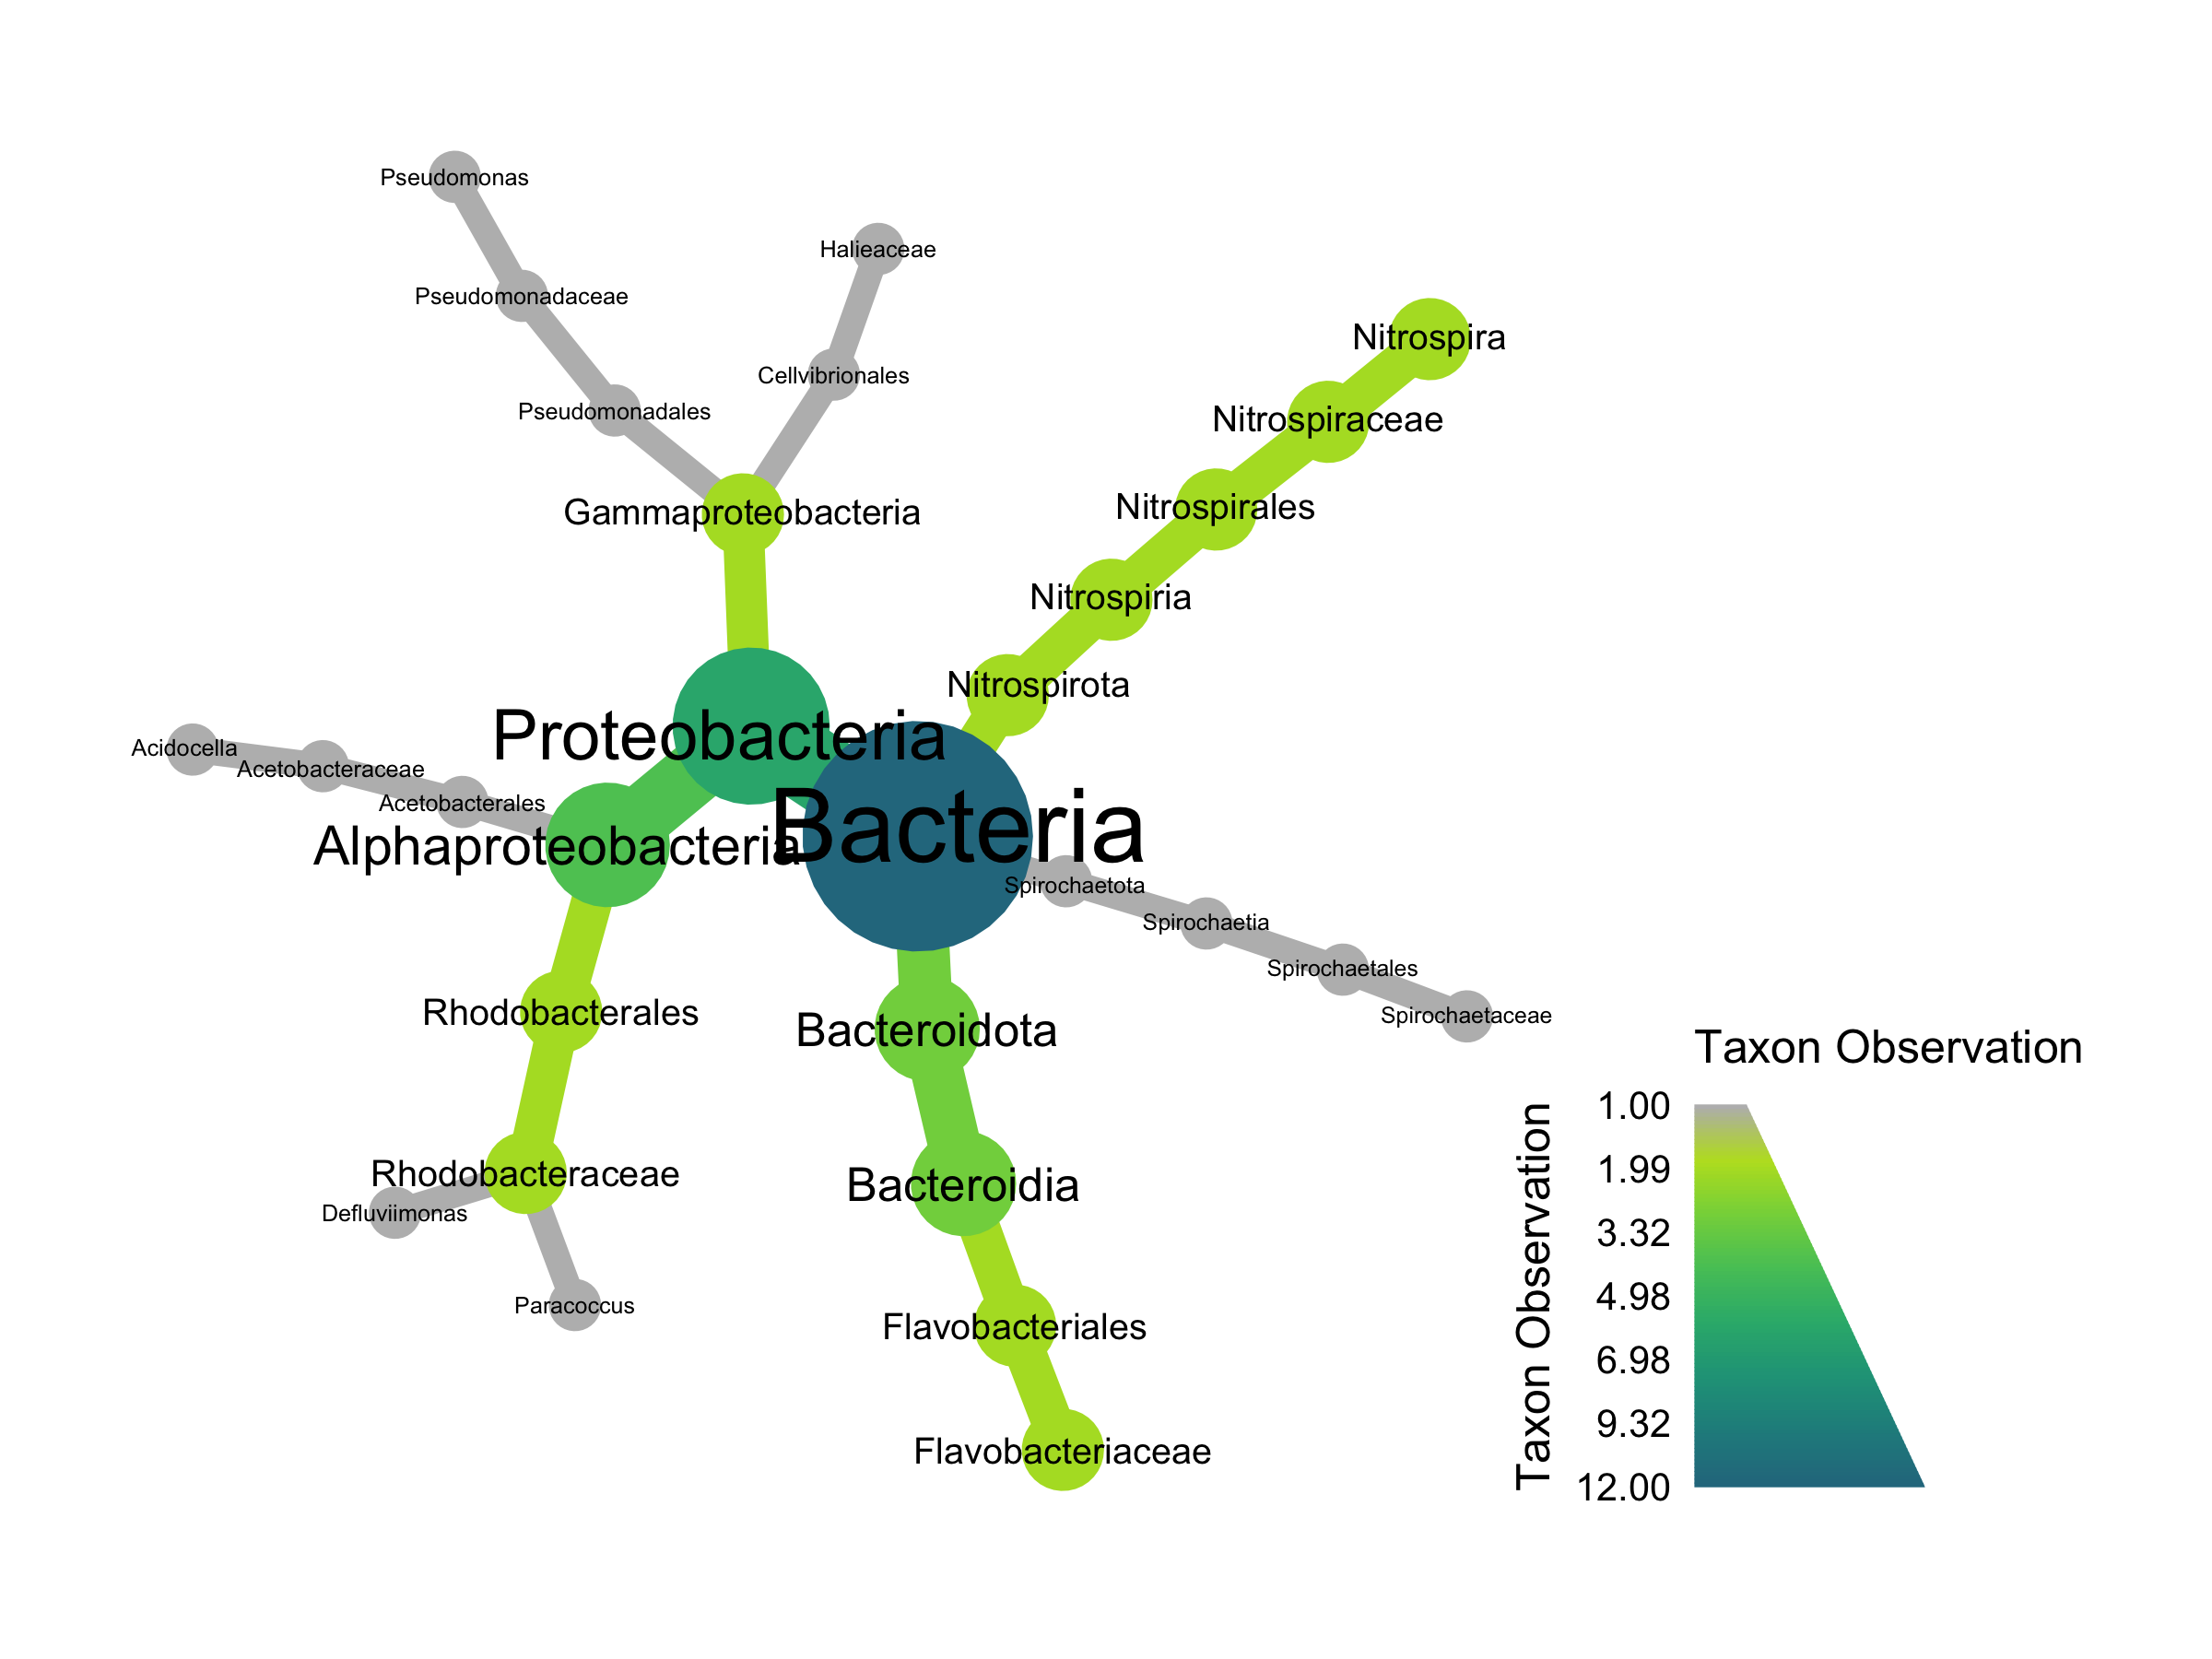

In [454]:
taxmapweight18CV %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapweight18CV),
            node_color = n_obs(taxmapweight18CV),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [480]:
##Fill in lowest taxonomic level for bargraph
weight18CV_df=as.data.frame(tax_table(sigweight18CV_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(weight18CV_df)]){
  weight18CV_df[[i]] <- (str_c(i, "_", weight18CV_df[[i]]))}

weight18CV_df=as.data.frame(t(weight18CV_df))
weight18CV_df=as.data.frame(t(fill(weight18CV_df, names(weight18CV_df))))
weight18CV_df$OTU=row.names(weight18CV_df)
weight18CV_df$log2FoldChange=as.numeric(weight18CV_df$log2FoldChange)

In [552]:
weight18CV_df$CV18weight=weight18CV_df$log2FoldChange
weight18CV_df$log2FoldChange=NULL

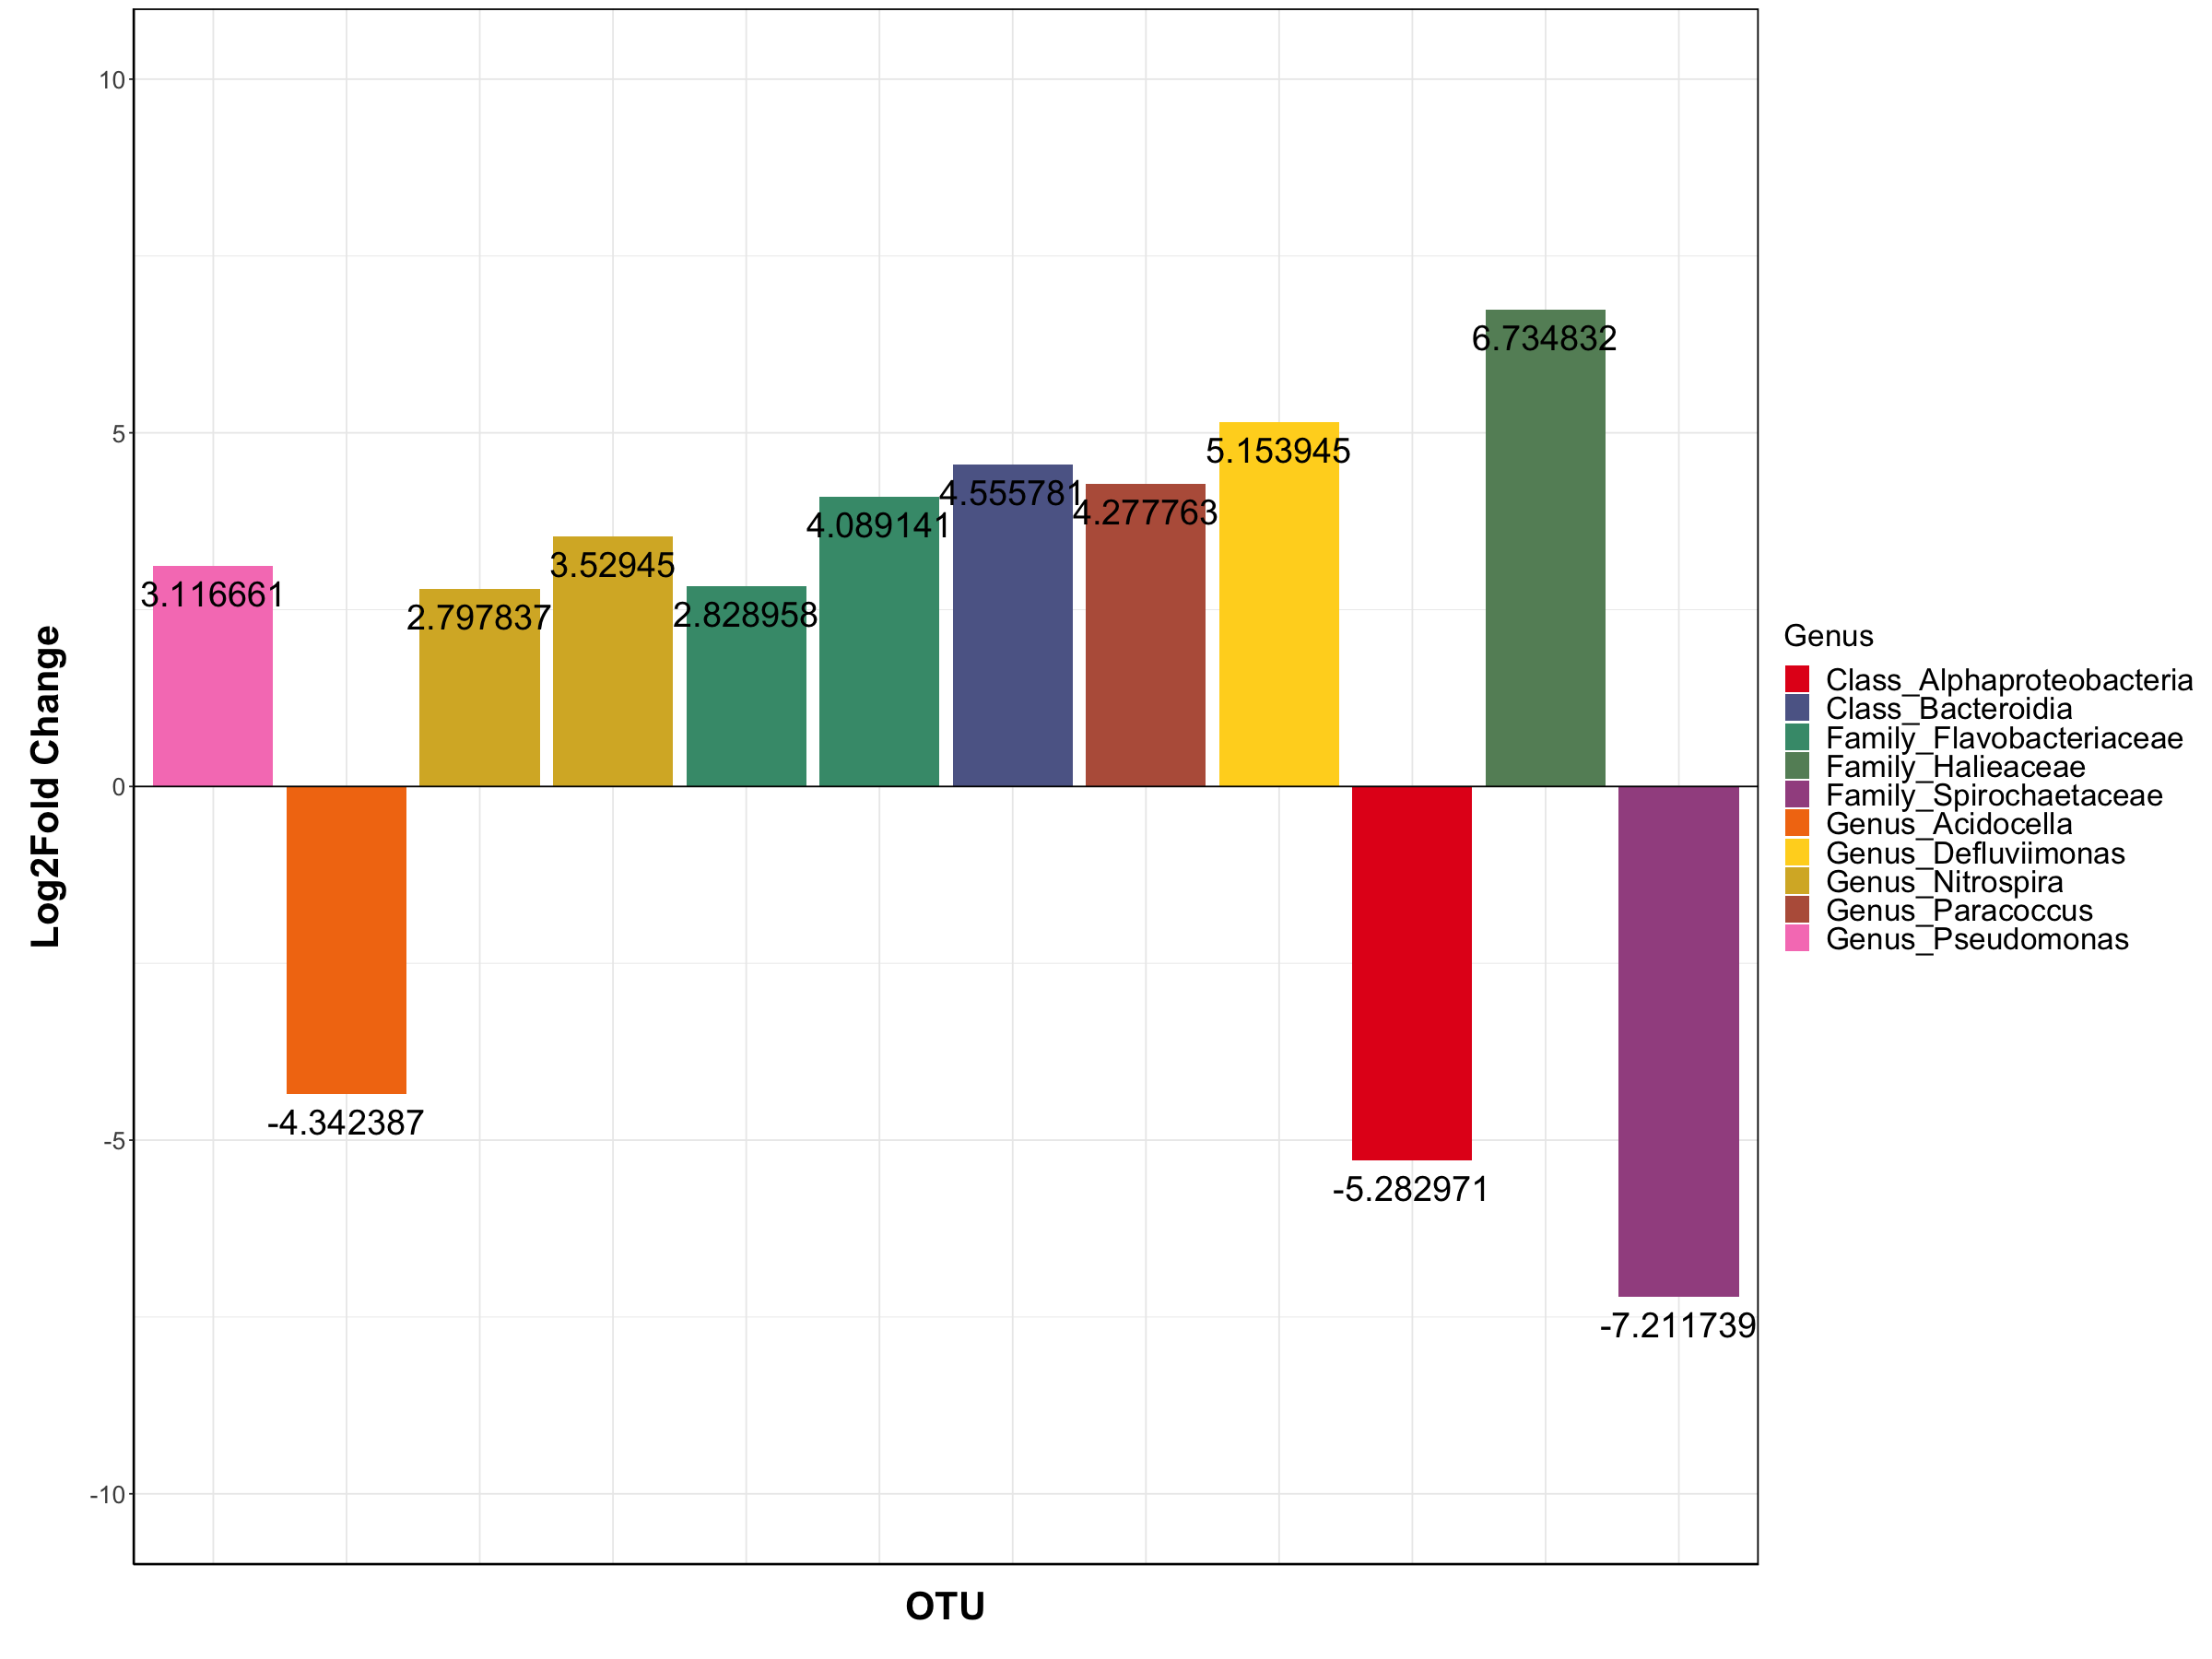

In [484]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(10)

ggplot(weight18CV_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-10, 10))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [485]:
resvol18CV <- results(dds_weight18CV, name="Volume_delta")
sigvol18CV <- resvol18CV[which(resvol18CV$padj < 0.05), ]
sigvol18CV <- cbind(as(sigvol18CV, "data.frame"), as(tax_table(DE18CVw)[rownames(sigvol18CV), ], "matrix"))
sigvol18CV=sigvol18CV[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol18CV <- as.matrix(sigvol18CV)

In [486]:
##turn into phyloseq object
sigvol18CVTAX <- tax_table(sigvol18CV)
sigvol18CV_wlog <- DE18CVw
tax_table(sigvol18CV_wlog)=sigvol18CVTAX

In [487]:
##filter for asvs found in 1/3 of samples
sigvol18CV_wlog_filter <- genefilter_sample(sigvol18CV_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol18CV_wlog))
sigvol18CV_wlog_prune <- prune_taxa(sigvol18CV_wlog_filter, sigvol18CV_wlog)

In [477]:
tax_table(sigvol18CV_wlog_prune)

log2FoldChange
TACGTATGGGGCAAACGTTGTTCGGATTCACTGGGCGTAAAGAGTACGTAGGCTGTCGAGACAGTCAATGATCAAATCCCGTAGCTTAACTACGTGGTCGTTGTTGATACTACTCGACTAGAGTTTTATAGAGGTAGCGGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAGGAACACCAAAGGCGAAGGCAAGCTACTGGGTAAAAACTGACGCTGAGGTACGAAAGCCAGGGGAGCAAATGGG   5.928079    
TACGGAGGATGCAAGTGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGTCTGGTAAGTCAGAGGTGAAAGACGGTGGCTCAACCATCGCAGTGCCCTTGATACTATTGGACTAGATTACATTGGAAGTAGGCGGAATGTGCGGTGTAGCGGTGAAATGCGCAGATATCGCACGGAACACCAATAGCGAAAGCAGCTTACTATACTGTTAATGACACTGAGGCACGAAAGCGTGGGTAGCAAATAGG -12.783548    
TACGAAGGTGGCAAGCGTTGTTCGGATTTACTGGGCGTACAGGGAGCGTAGGCGGTTAGGTAAGCCCTTCGTGAAATCTCCGGGCCTAACCCGGAAAGTGCGGGGGGGACTGCTTAGCTAGAGGATGGGAGAGGAGCGCGGAATTCCCGGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAAGGCCGGTGGCGAAGGCGGCGCTCTGGAACATTTCTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG  -5.368475    
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  -5.036607    
TACGGAGGATGCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGATGGTTAAGTCAGGGGTGAAAGTCTTCAGCTCAACTGAAGAACTGCCTTTGATACTGGCTATCTTGAATTACTGTGAAGTGGTTAGAATATGTAGTGTAGCGGTGAAATGCATAGATATTACATAGAATACCGATTGCGAAGGCAGATCACTAACAGTATATTGACGCTGATGGACGAAAGCGTGGGGAGCGAACAGG  -7.000612    
TACGGAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGTGGAAGATTAAGTCAGAGGTGAAATCCTGCAGCTCAACTGTAGAATTGCCTTTGATACTGGTTTTCTTGAATCATTATGAAGTAGTTAGAATATGTAGTGTAGCGGTGAAATGCATAGATATTACATAGAATACCAATTGCGAAGGCAGATTACTAATAATGTATTGACACTGATGGACGAAAGCGTGGGGAGCGAACAGG  -5.397940    
TACGGAAGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGTGGTTTTGTAAGTCGGATGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTCGATACTGCAAGACTAGAGTATGTTAGAGGGAAGTGGAATTCCGGGTGTAGCGGTGAAATGCGTAGATATCCGGAGGAACACCAATGGCGAAGGCAACTTCCTGGGACAATACTGACACTGAGGTGCGAAAGCGTGGGTAGCAAACAGG  -7.946284    
TACGAAGGTGGCGAGCGTTGTTCGGATTTACTGGGCGTAAAGAGCACGTAGGCGGTTGGGTAAGCCTCTTGGGAAAGCTCCCGGCTTAACCGGGAAAGGTCGAGGGGAACTACTCAGCTAGAGGACGGGAGAGGAGCGCGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAAGGCCGGTGGCGAAGGCGGCGCTCTGGAACGTACCTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  -6.759684    
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTGTGTAAGACAGGTGTGAAATCCCCGGGCTTAACCTGGGAACTGCGCTTGTGACTGCACAGCTAGAGTACGGCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGG  -8.147799    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTCCAAAACTATCAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG -10.512210    
TACGGGGGGTGCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTTTTATAAGTCAGATGTGAAAGCCCTGGGCTTAACCTGGGAAGAGCATTTGAAACTATTGAACTTGAGTACGGTAGAGGAAAGCGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGTGGCGAAGGCGGCTTTCTGGACCTGTACTGACGCTGAGGCGCGAAGGCGTGGGTAGCGAACGGG  -6.044350    
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGTTAAGTCGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCACCCGATACTGGCCGACTAGAGTACGAGAGAGGGAGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAATACCAGTGGCGAAGGCGGCCTCCTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG -11.147906    
TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGCTTTGCAAGTCGGGTGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAGACTGCATTGCTCGAGTATGGGAGAGGGAAGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGATATCGGAAGGAACATCAGTGGCGAAGGCGACTTCCTGGACCAATACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG  -7.460594    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACTGGAAAGTTGGAGGTGAAATCCCAGGGCTCAACCTTGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  -9.685016    
                                                                                                                                                                                                                           

In [488]:
##Heattree
vol18CV=sigvol18CV_wlog_prune
tax_table(vol18CV) <- tax_table(vol18CV)[,2:7]
taxmapvol18CV <- parse_phyloseq(vol18CV)

The following 8 of 14 (57.1%) input indexes have `NA` in their classifications:
   1, 2, 5, 6, 7, 11, 12, 13




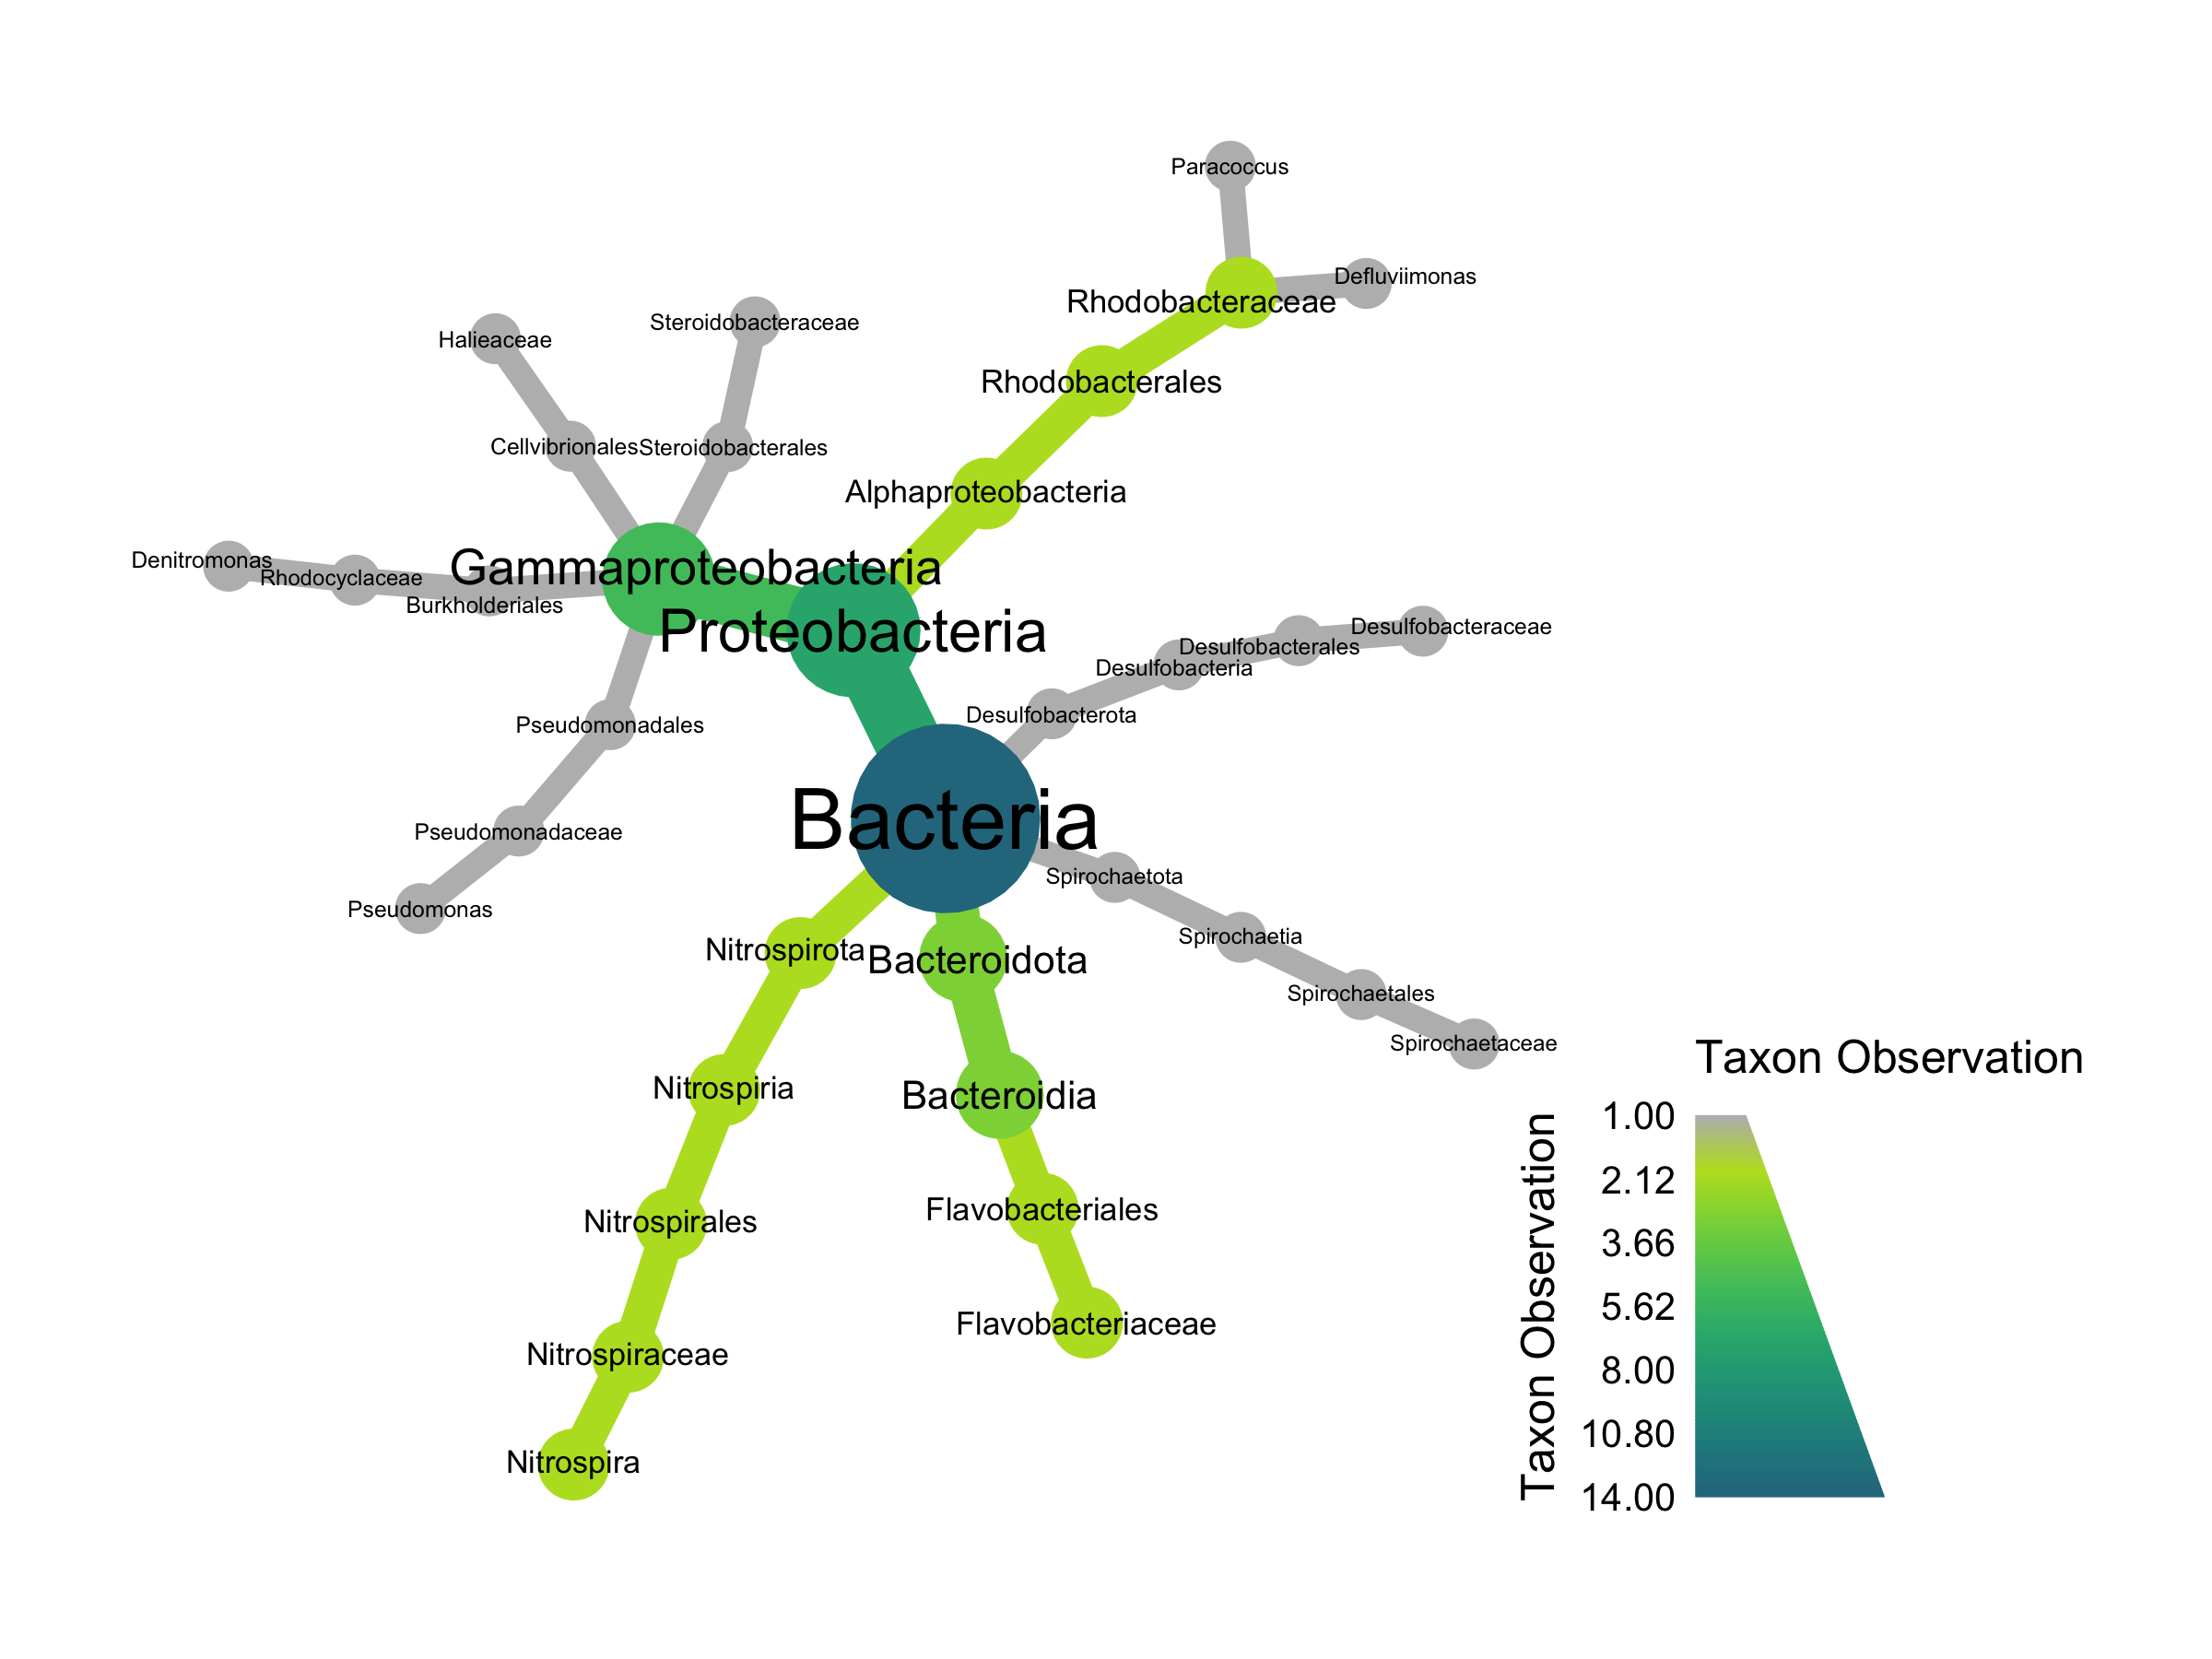

In [490]:
taxmapvol18CV %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapvol18CV),
            node_color = n_obs(taxmapvol18CV),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [491]:
##Fill in lowest taxonomic level for bargraph
vol18CV_df=as.data.frame(tax_table(sigvol18CV_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(vol18CV_df)]){
  vol18CV_df[[i]] <- (str_c(i, "_", vol18CV_df[[i]]))}

vol18CV_df=as.data.frame(t(vol18CV_df))
vol18CV_df=as.data.frame(t(fill(vol18CV_df, names(vol18CV_df))))
vol18CV_df$OTU=row.names(vol18CV_df)
vol18CV_df$log2FoldChange=as.numeric(vol18CV_df$log2FoldChange)

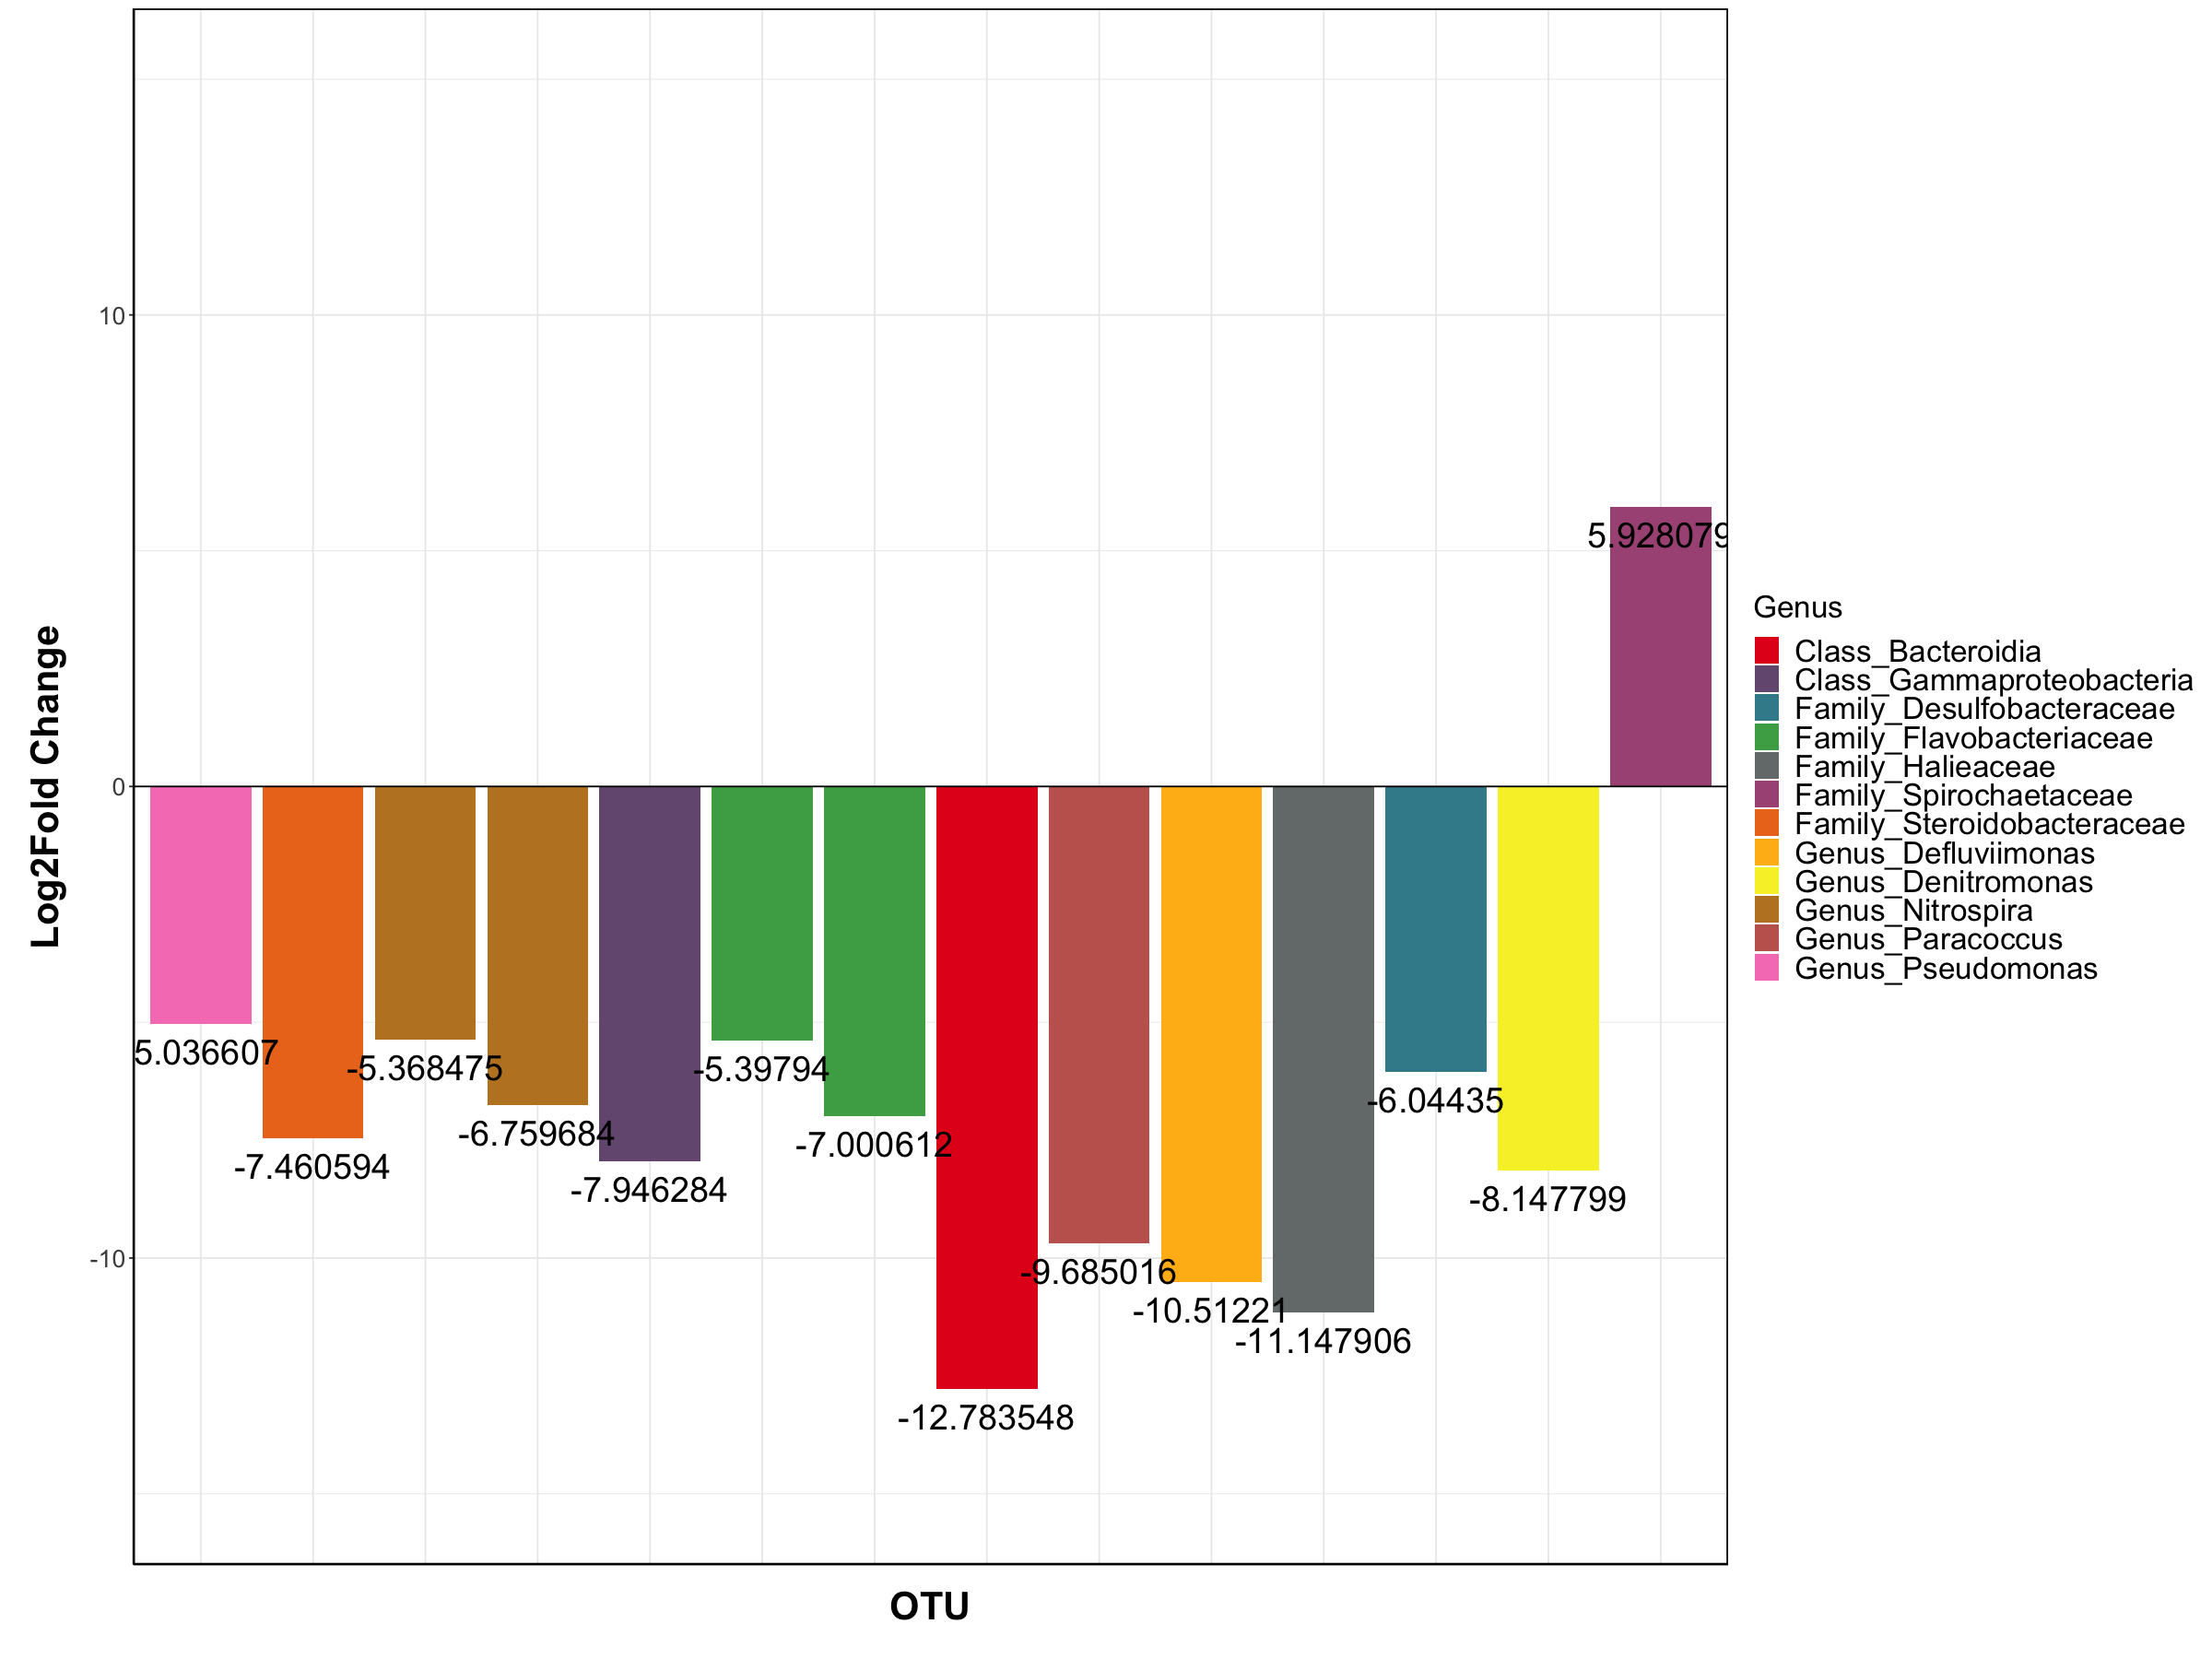

In [494]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(12)

ggplot(vol18CV_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-15, 15))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [551]:
vol18CV_df$CV18vol=vol18CV_df$log2FoldChange
vol18CV_df$log2FoldChange=NULL

## 2018 Mussels

In [576]:
DE18IR=subset_samples(DE18, Species=="IR")
DE18IRw=subset_samples(DE18IR, !is.na(Weight_delta))

In [577]:
dds_weight18IR <- phyloseq_to_deseq2(DE18IRw, ~ Weight_delta+Volume_delta)
dds_weight18IR <- DESeq(dds_weight18IR, test="Wald", fitType="parametric")
resultsNames(dds_weight18IR)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"    "Weight_delta" "Volume_delta"

In [578]:
resweight18IR <- results(dds_weight18IR, name="Weight_delta")
sigweight18IR <- resweight18IR[which(resweight18IR$padj < 0.05), ]
sigweight18IR <- cbind(as(sigweight18IR, "data.frame"), as(tax_table(DE18IRw)[rownames(sigweight18IR), ], "matrix"))
sigweight18IR=sigweight18IR[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigweight18IR <- as.matrix(sigweight18IR)

In [579]:
sigweight18IR

log2FoldChange
TACGTAGGGGGCGAACGTTGTTCGGAATCACTGGGCGTAAAGGGTGCGCAGGCTGCTCATCAAGTCAGTTGTGAAATTTCGTGGCTCAACCACGAAGCTGCTGCTGATACTGTTGGGCTAGAGTCATAGATAGAGGTAGCGGGAATTCCTGGTGTAGGAGTGAAATCTGTAGATATCAGGAGGAACACCAAGGGTGAAGACAAGCTACTGGGTAATGACTGACGCTGAGGCACGAAAGCTAGGGGAGCAAATGGG                   -10.817549    
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                      -30.000000    
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG                     -13.760238    
TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGACACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG                     -15.601012    
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGTCTTGTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGTAAGACTAGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATGGACGAAAGCCAGGGGAGCGAAAGGG                      -8.071278    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGATTATTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTATTAGTCTAGAGTCCGGGAGAGGTGAGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                     -30.000000    
TACGTAGGGGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGCGTGCGTAGGCGGCTTGAGAGGTCAGAGGTGAAAGGCATGGGCTCAACCCATGTAAGCCTTTGAAACCGGCAGGCTTGAGATCAGGAGGGGAAAGTGGAATTTCTAGTGTAGCGGTGGAATGCGTAGATATTAGAAGGAACACCAGTGGCGAAGGCGACTTTCTGGACTGATACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAGG                      -30.000000    
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGTAAGTCGGGTGTGAAATCTCCAAGCTTAACTTGGAAACTGCACTCGATACTGCGTCGCTCGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGAAATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCAAACGGG                      -6.234587    
TACGTAGGTCCCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTCCGTAGACGGTTTATTAAGTCTGATGTGAAAGCCACCGGCTCAACCGGTGAAACGCATTAGATACTGGTAAACTAGAGTATGTTAGAGGATAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTATCTGGGACATTACTGACGTTGAGGGACGAAAGCGTGGGGAGCGAACAGG                     -30.000000    
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGCGTGTTAAGTCAGATGTGAAAGCCCTGGGCTTAACCTGGGAACTGCATTTGATACTGGCATGCTAGAGTTTGGTAGAGGTAAGTGGAATTCCGGGTGTAGCGGTGAAATGCGTAGATATCCGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACCAAAACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                      14.304063    
TACGTAAGGGGCAAGTGTTGTTCGGAATTATTGGGTGTAAAGGGCATGTAGGCGGTTTAATAAGTCTAATATTAAAGACTCAAGCTCAACTTGAGGAATGTGTTAGAAACTATCAAACTAGAGTTTAGAAGAGGAAAATAGAATTTCTAGTGTAGGGGTGATATCTTCAGATATTAGGAGGAATGCCAGAGGTGAAGGCGATTTTCTAGTCTAAAACTGACGCTGATATGCGAAAGCATGGGTAGCAAACTGA                     -30.000000    
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGGTGTGAAATCCCCGGGCTTAACCTGGGAACTGCGCTTGTGACTGCAAGACTGGAGTGTGGCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGTTAACACTGACGCTCATGCACGAAAGCGTGGGTAGCAAACAGG                     -30.000000    
TACGAAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGAGTACGTAGGCGGTTAGATTAGTTAGGTGTGAAATCCCGGAGCTCAACTTCGGAGTTGCACTTAATACTGTTTAACTAGAATTCAAGAGGGGAGAGTGGAATTTCCAGTGTAGGGGTGATATCCGTAGATATTGGAAGGAACATCAGAGGCGAAGGCGACTCTCTGGCTTGACATTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACAGG                     -30.000000    
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGCCTTTTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGGAAGGCTTGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATG

In [580]:
##turn into phyloseq object
sigweight18IRTAX <- tax_table(sigweight18IR)
sigweight18IR_wlog <- DE18IRw
tax_table(sigweight18IR_wlog)=sigweight18IRTAX

In [581]:
##filter for asvs found in 1/3 of samples
sigweight18IR_wlog_filter <- genefilter_sample(sigweight18IR_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigweight18IR_wlog))
sigweight18IR_wlog_prune <- prune_taxa(sigweight18IR_wlog_filter, sigweight18IR_wlog)

In [582]:
tax_table(sigweight18IR_wlog_prune)

log2FoldChange
TACGTAGGGGGCGAACGTTGTTCGGAATCACTGGGCGTAAAGGGTGCGCAGGCTGCTCATCAAGTCAGTTGTGAAATTTCGTGGCTCAACCACGAAGCTGCTGCTGATACTGTTGGGCTAGAGTCATAGATAGAGGTAGCGGGAATTCCTGGTGTAGGAGTGAAATCTGTAGATATCAGGAGGAACACCAAGGGTGAAGACAAGCTACTGGGTAATGACTGACGCTGAGGCACGAAAGCTAGGGGAGCAAATGGG -10.817549    
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG   -13.760238    
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGTCTTGTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGTAAGACTAGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATGGACGAAAGCCAGGGGAGCGAAAGGG    -8.071278    
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGTAAGTCGGGTGTGAAATCTCCAAGCTTAACTTGGAAACTGCACTCGATACTGCGTCGCTCGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGAAATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCAAACGGG    -6.234587    
TACGGGAGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCCGCAGGCGGCCTTTTAAGTCTGTTGTTAAAGCGTGGAGCTTAACTCCATTTCAGCAATGGAAACTGGAAGGCTTGAGTGTGGTAGGGGCAGAGGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAGGCGCTCTGCTGGGCCATAACTGACGCTCATGGACGAAAGCCAGGGGAGCGAAAGGG    -8.489571    
GACGAACCAAGCGAACGTTATTCGGAATTACTGGGCTTAAAGCGCGTGTAGGCGGATTGCCACGTCGGCTGTTGAAATCCCCCGGCTCAACCGGGGAACAGGCACCGATACGAGTGATCTTGAGGTGGGTAGGGGAGACTGGAACTTCCGGTGGAGCGGTGAAATGCGTTGAGATCGGAAGGAACGCCCGCGGCGAAAGCGAGTCTCTGGCCCCATACTGACGCTGAGACGCGAAAGCCAGGGGAGCAAACGGG   -9.974603    
TACAGAGGGCTCGAGCGTTAATCGGAATCACTGGGCTTAAAGCGTGCGTAGGCGGGCGTGTAAGCATCTTGTGAAAGCCCCCGGCTCAACCGGGGAATTGCTTGGTGAACTGCACGTCTTGAGGCAAGTAGAGGTGGTCGGAACGATAGGTGGAGCGGTGAAATGCGTAGATATCTATCGGAACGCCAACGGAGAAGTCAGGCCACTGGGCTTGTTCTGACGCTGAGGCACGAAAGCGTGGGTAGCGAACGGG    -7.030132    
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG    10.934394    
TACGTAGGGTGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGTAGGCGGTTAGTCACGTCGGATGTGAAAACCCAGTGCTTAACACTGGGCCTGCATTCGATACGGGCTGACTAGAGTGTTGTAGGGGAGACTGGAACTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAAGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAACTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACAGG    -8.518110    
TACGAAGGGACCTAGCGTAGTTCGGAATTACTGGGCTTAAAGAGTTCGTAGGTGGTTAAAAAAGTTGATGGTGAAATCCCAAGGCTCAACCTTGGAACTGCCATCAAAACTTTTTAGCTAGAGTGTGATAGAGGAAAGTGGAATTTCTAGTGTAGAGGTGAAATTCGTAGATATTAGAAAGAACATCAAAAGCGAAGGCAACTTTCTGGATCATTACTGACACTGAGGAACGAAAGCATGGGTAGCGAAGAGG    -8.847271    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG   -11.911470    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGATCTTTAAGTCAGGGGTGAAATCCTGGGGCTCAACCTCAGAACTGCCCTTGATACTGAAGATCTTGAGTCCGGAAGAGGTTAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTAACTGGTCCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG    -9.561540    
TACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGCATACACAGTCAGATGTGAAATTCCTGGGCTCAACCTGGGGACTGCATTTGATACGTGTGAGCTAGAGTGGAGAAGAGGGTTGTGGAATTTCCAGTGTAGAGGTGAAATTCGTAGATATTGGAAAGAACACCGGTGGCGAAGGCGGCAACCTGGTCTTTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG    -9.403656    
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG    -6.578052    
                                                                                                                                                                                               

In [583]:
##Heattree
weight18IR=sigweight18IR_wlog_prune
tax_table(weight18IR) <- tax_table(weight18IR)[,2:7]
taxmapweight18IR <- parse_phyloseq(weight18IR)

The following 6 of 14 (42.9%) input indexes have `NA` in their classifications:
   1, 2, 6, 9, 10, 14




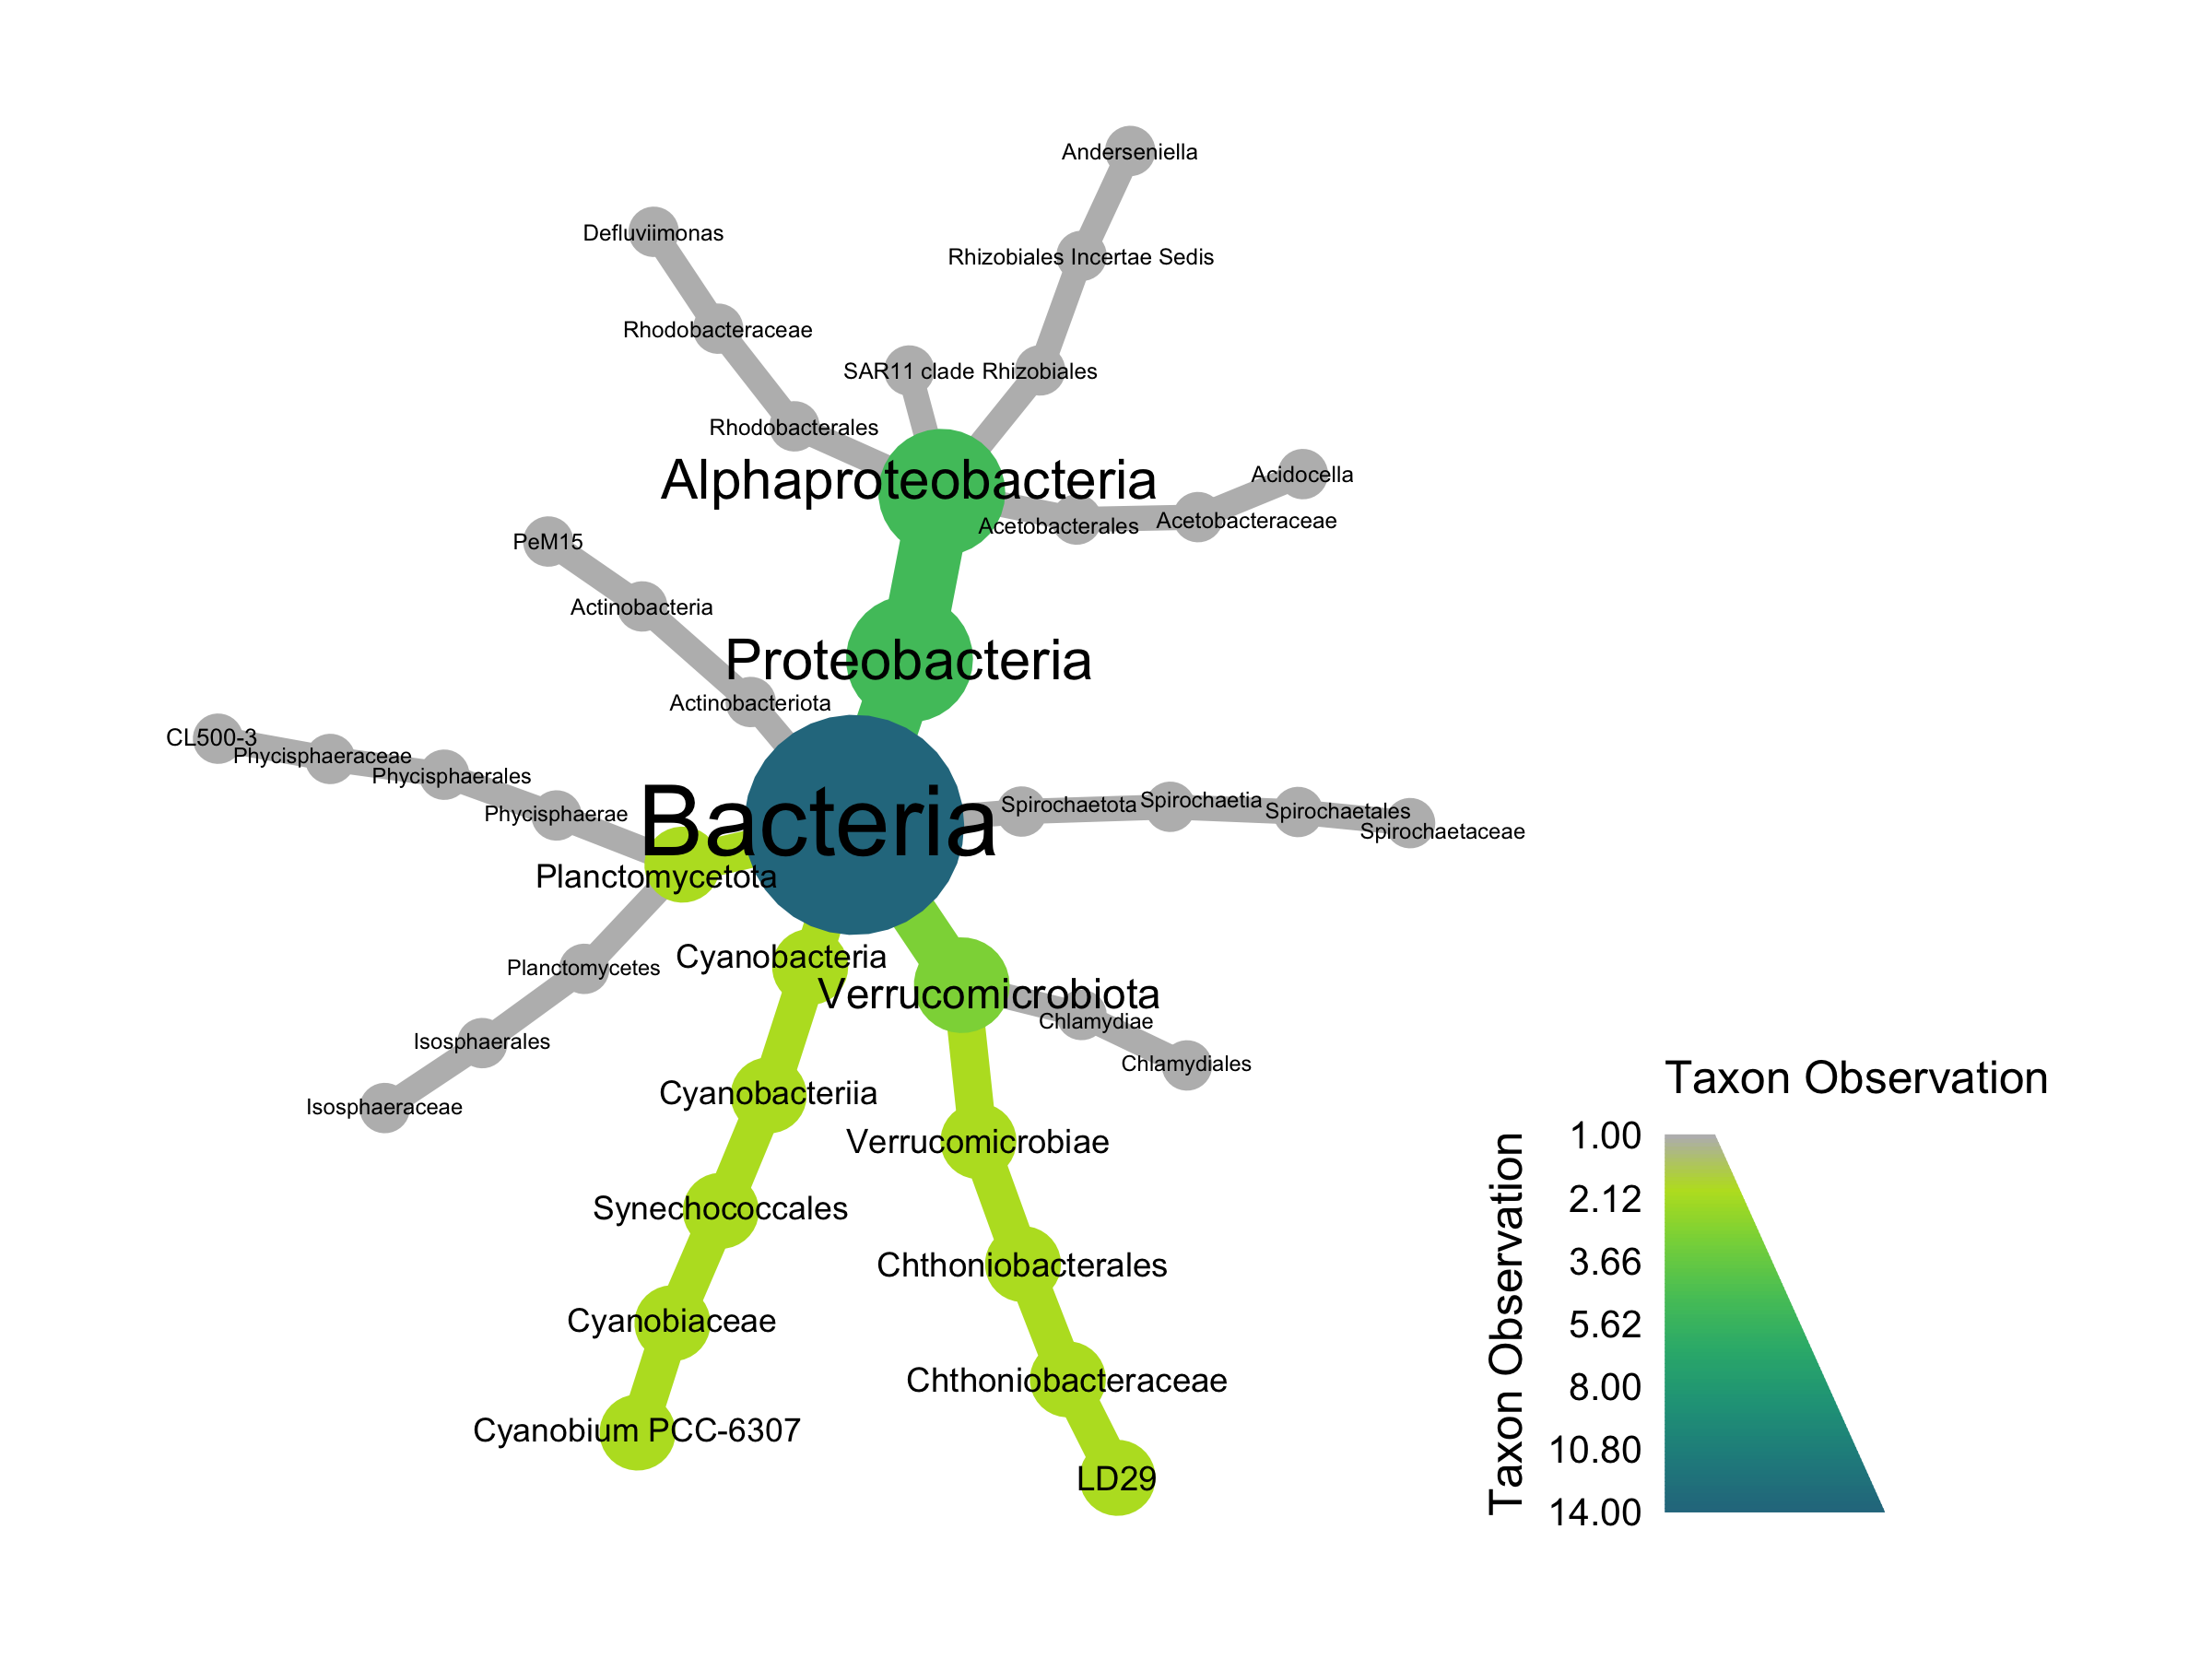

In [584]:
taxmapweight18IR %>% 
  heat_tree(node_label = taxon_names,
            node_size = n_obs(taxmapweight18IR),
            node_color = n_obs(taxmapweight18IR),
            layout = "davidson-harel", initial_layout = "reingold-tilford", 
            node_legend_title	= "Taxon Observation", 
            node_color_axis_label ="Taxon Observation",
            margin_size = c(0.1, 0.1, 0.1, 0.1))+
  theme(legend.position = "none", 
        legend.text=element_text(size=8),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "bold", hjust = 0.5, size = 15, colour = "black", margin=margin(15, 15, 0, 15)), 
        plot.subtitle = element_text(face = "bold", hjust = 0.5, color = "black", margin=margin(15, 15, 15, 15), ),
        plot.caption = element_text(color = "black", face = "italic", margin=margin(15, 15, 15, 15)),
        axis.title.x = element_blank(), 
        axis.title.y = element_blank())

In [585]:
##Fill in lowest taxonomic level for bargraph
weight18IR_df=as.data.frame(tax_table(sigweight18IR_wlog_prune))
for (i in colnames(weight18CV_df)[2:NCOL(weight18IR_df)]){
  weight18IR_df[[i]] <- (str_c(i, "_", weight18IR_df[[i]]))}

weight18IR_df=as.data.frame(t(weight18IR_df))
weight18IR_df=as.data.frame(t(fill(weight18IR_df, names(weight18IR_df))))
weight18IR_df$OTU=row.names(weight18IR_df)
weight18IR_df$log2FoldChange=as.numeric(weight18IR_df$log2FoldChange)

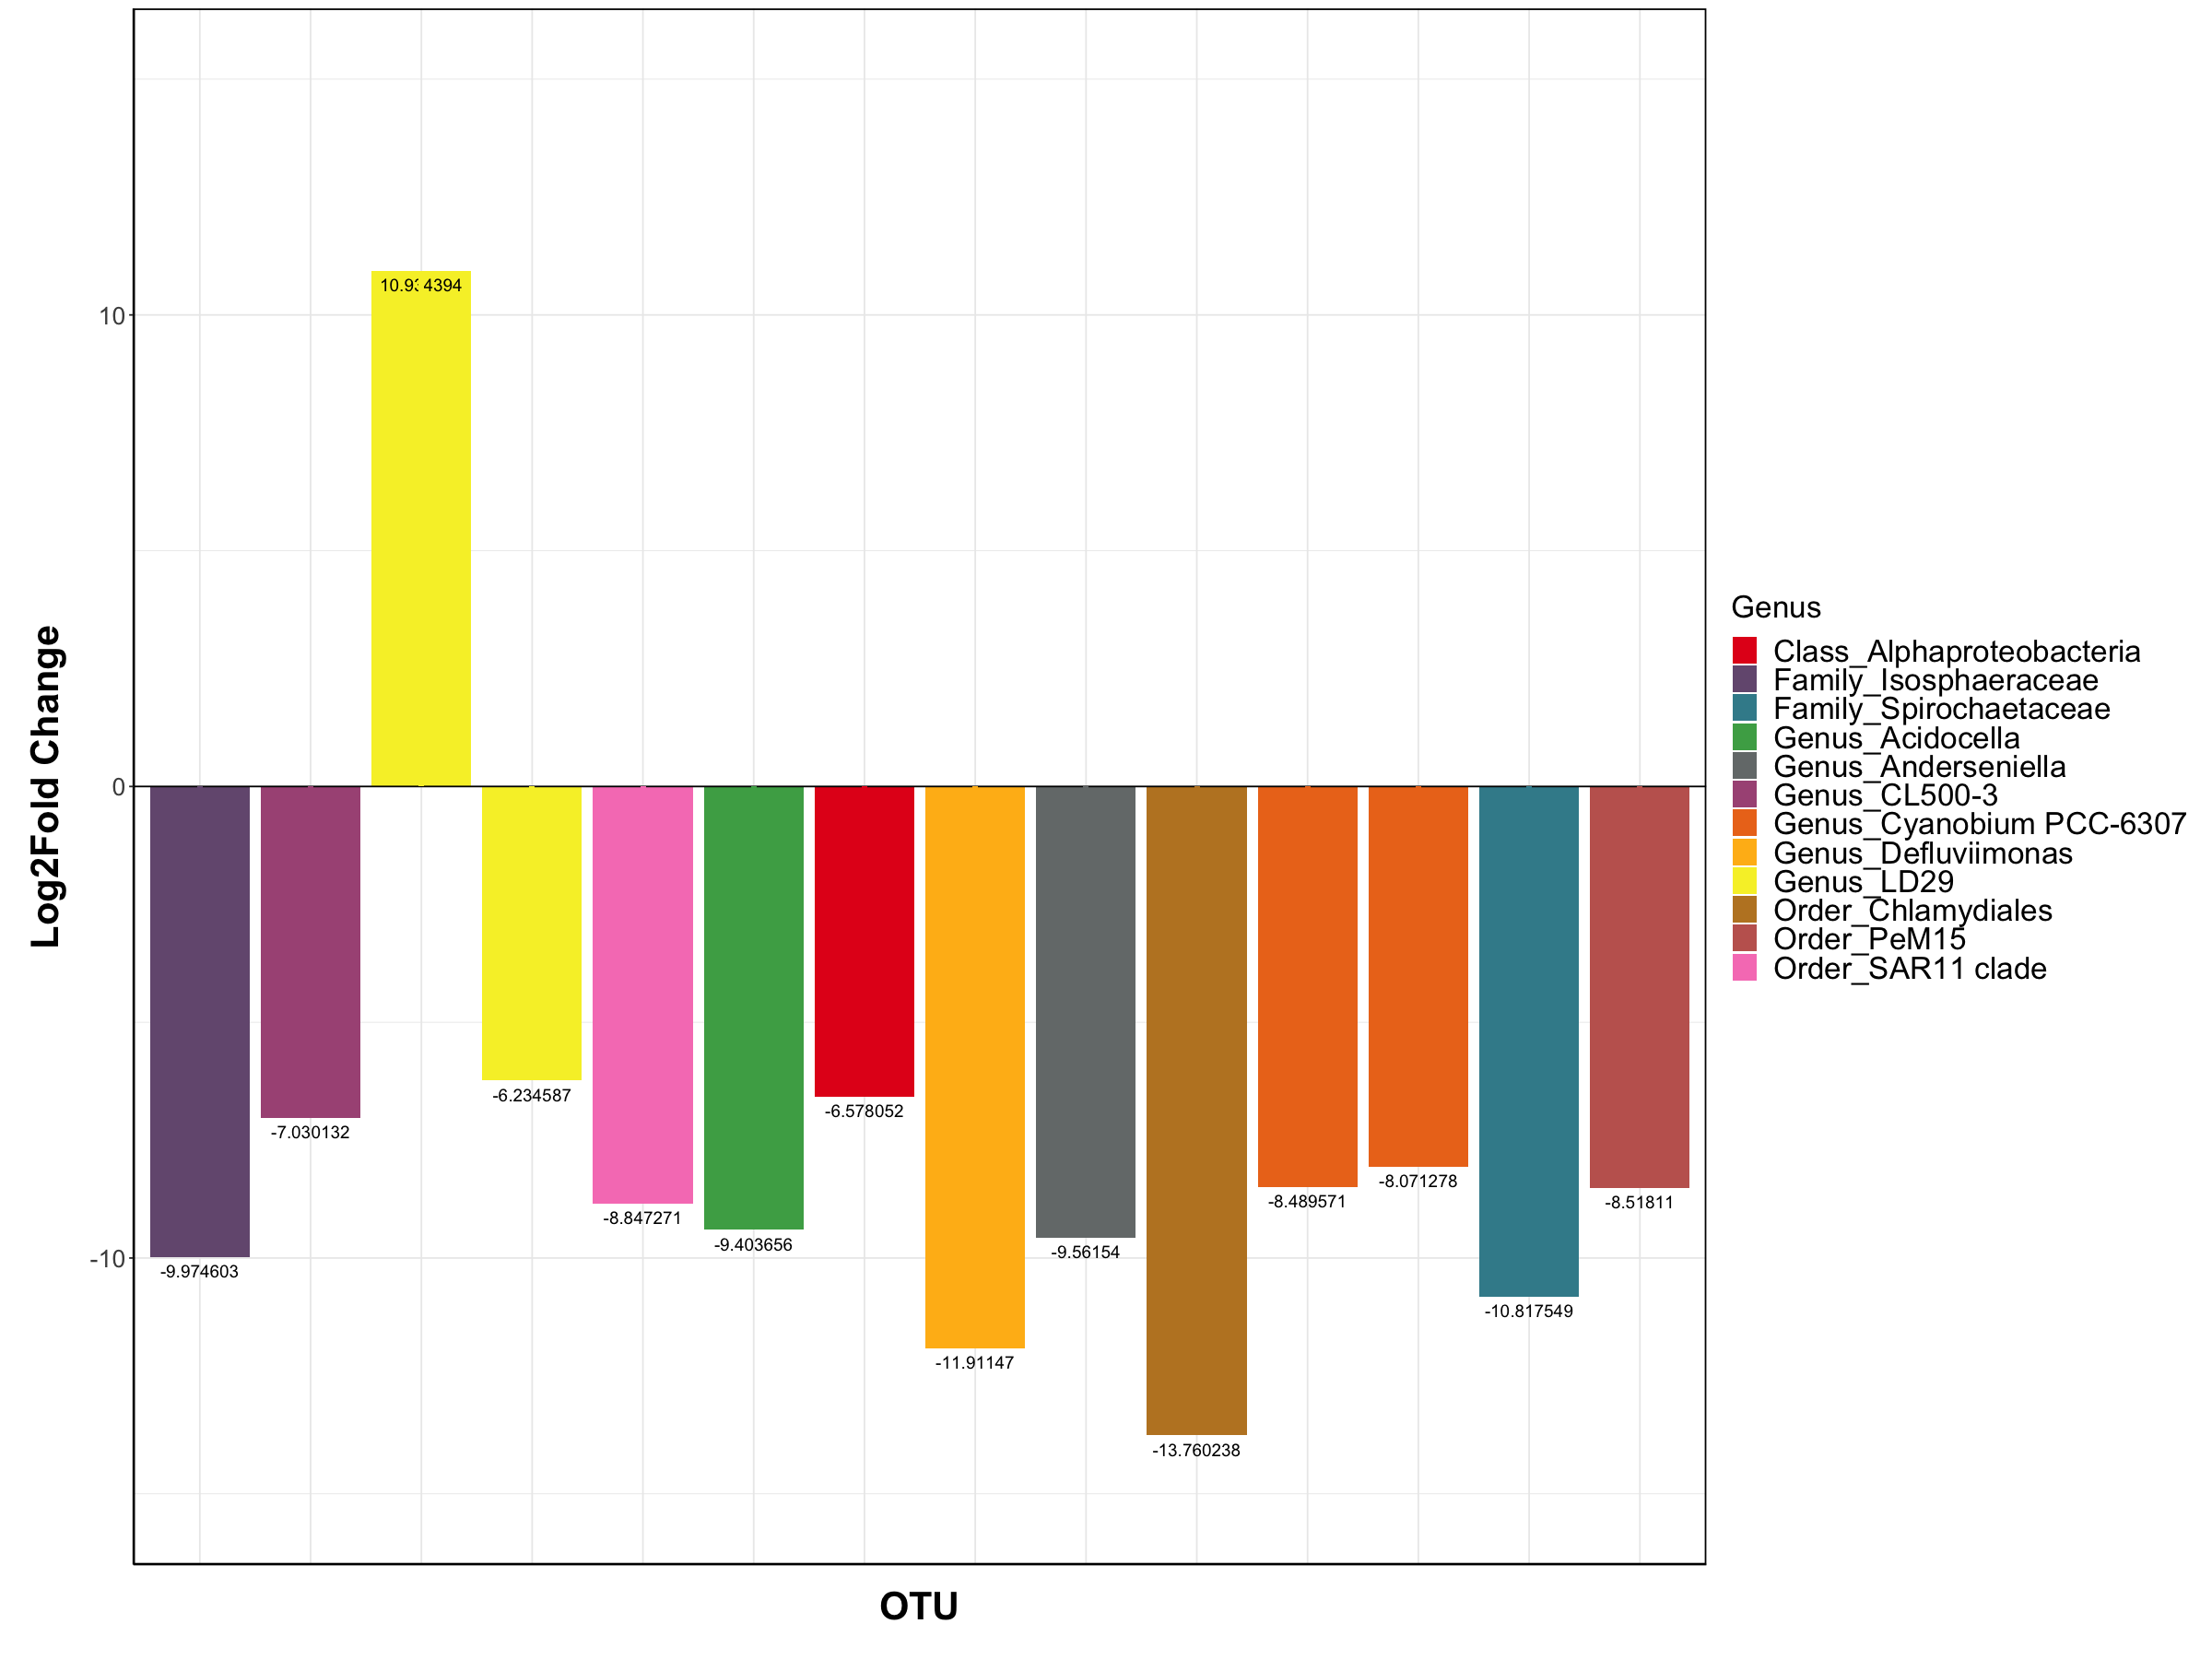

In [586]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(12)

ggplot(weight18IR_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=4)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-15, 15))+
  geom_hline(yintercept = 0)+
geom_col(width = 0.05)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [518]:
ggsave(file="~/Documents/DE/Figures/IRweight_bar.pdf", width = 15, height=10)

In [587]:
weight18IR_df$IR18weight=weight18IR_df$log2FoldChange
weight18IR_df$log2FoldChange=NULL

In [597]:
resvol18IR <- results(dds_weight18IR, name="Volume_delta")
sigvol18IR <- resvol18IR[which(resvol18IR$padj < 0.05), ]
sigvol18IR <- cbind(as(sigvol18IR, "data.frame"), as(tax_table(DE18IRw)[rownames(sigvol18IR), ], "matrix"))
sigvol18IR=sigvol18IR[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sigvol18IR <- as.matrix(sigvol18IR)

In [598]:
##turn into phyloseq object
sigvol18IRTAX <- tax_table(sigvol18IR)
sigvol18IR_wlog <- DE18IRw
tax_table(sigvol18IR_wlog)=sigvol18IRTAX

In [599]:
##filter for asvs found in 1/3 of samples
sigvol18IR_wlog_filter <- genefilter_sample(sigvol18IR_wlog, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sigvol18IR_wlog))
sigvol18IR_wlog_prune <- prune_taxa(sigvol18IR_wlog_filter, sigvol18IR_wlog)

In [600]:
tax_table(sigvol18IR_wlog_prune)

log2FoldChange
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG   9.623932    
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG -20.532182    
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG   9.547071    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  10.950357    
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG   6.886954    
                                                                                                                                                                                                                                                              Kingdom 
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Bacteria
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Bacteria
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG Bacteria
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG Bacteria
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG Bacteria
                                                                                                                                                                                                                                                              Phylum           
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Verrucomicrobiota
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Verrucomicrobiota
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGC

In [601]:
##Fill in lowest taxonomic level for bargraph
vol18IR_df=as.data.frame(tax_table(sigvol18IR_wlog_prune))
for (i in colnames(vol18IR_df)[2:NCOL(vol18IR_df)]){
 vol18IR_df[[i]] <- (str_c(i, "_", vol18IR_df[[i]]))}
vol18IR_df=as.data.frame(t(vol18IR_df))
vol18IR_df=as.data.frame(t(fill(vol18IR_df, names(vol18IR_df))))
vol18IR_df$OTU=row.names(vol18IR_df)
vol18IR_df$log2FoldChange=as.numeric(vol18IR_df$log2FoldChange)


In [602]:
vol18IR_df

log2FoldChange
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG   9.623932    
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG -20.532182    
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG   9.547071    
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  10.950357    
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG   6.886954    
                                                                                                                                                                                                                                                              Kingdom         
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Kingdom_Bacteria
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Kingdom_Bacteria
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG Kingdom_Bacteria
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
                                                                                                                                                                                                                                                              Phylum                  
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Phylum_Verrucomicrobiota
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Phylum_Verrucomicrobiota
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAG

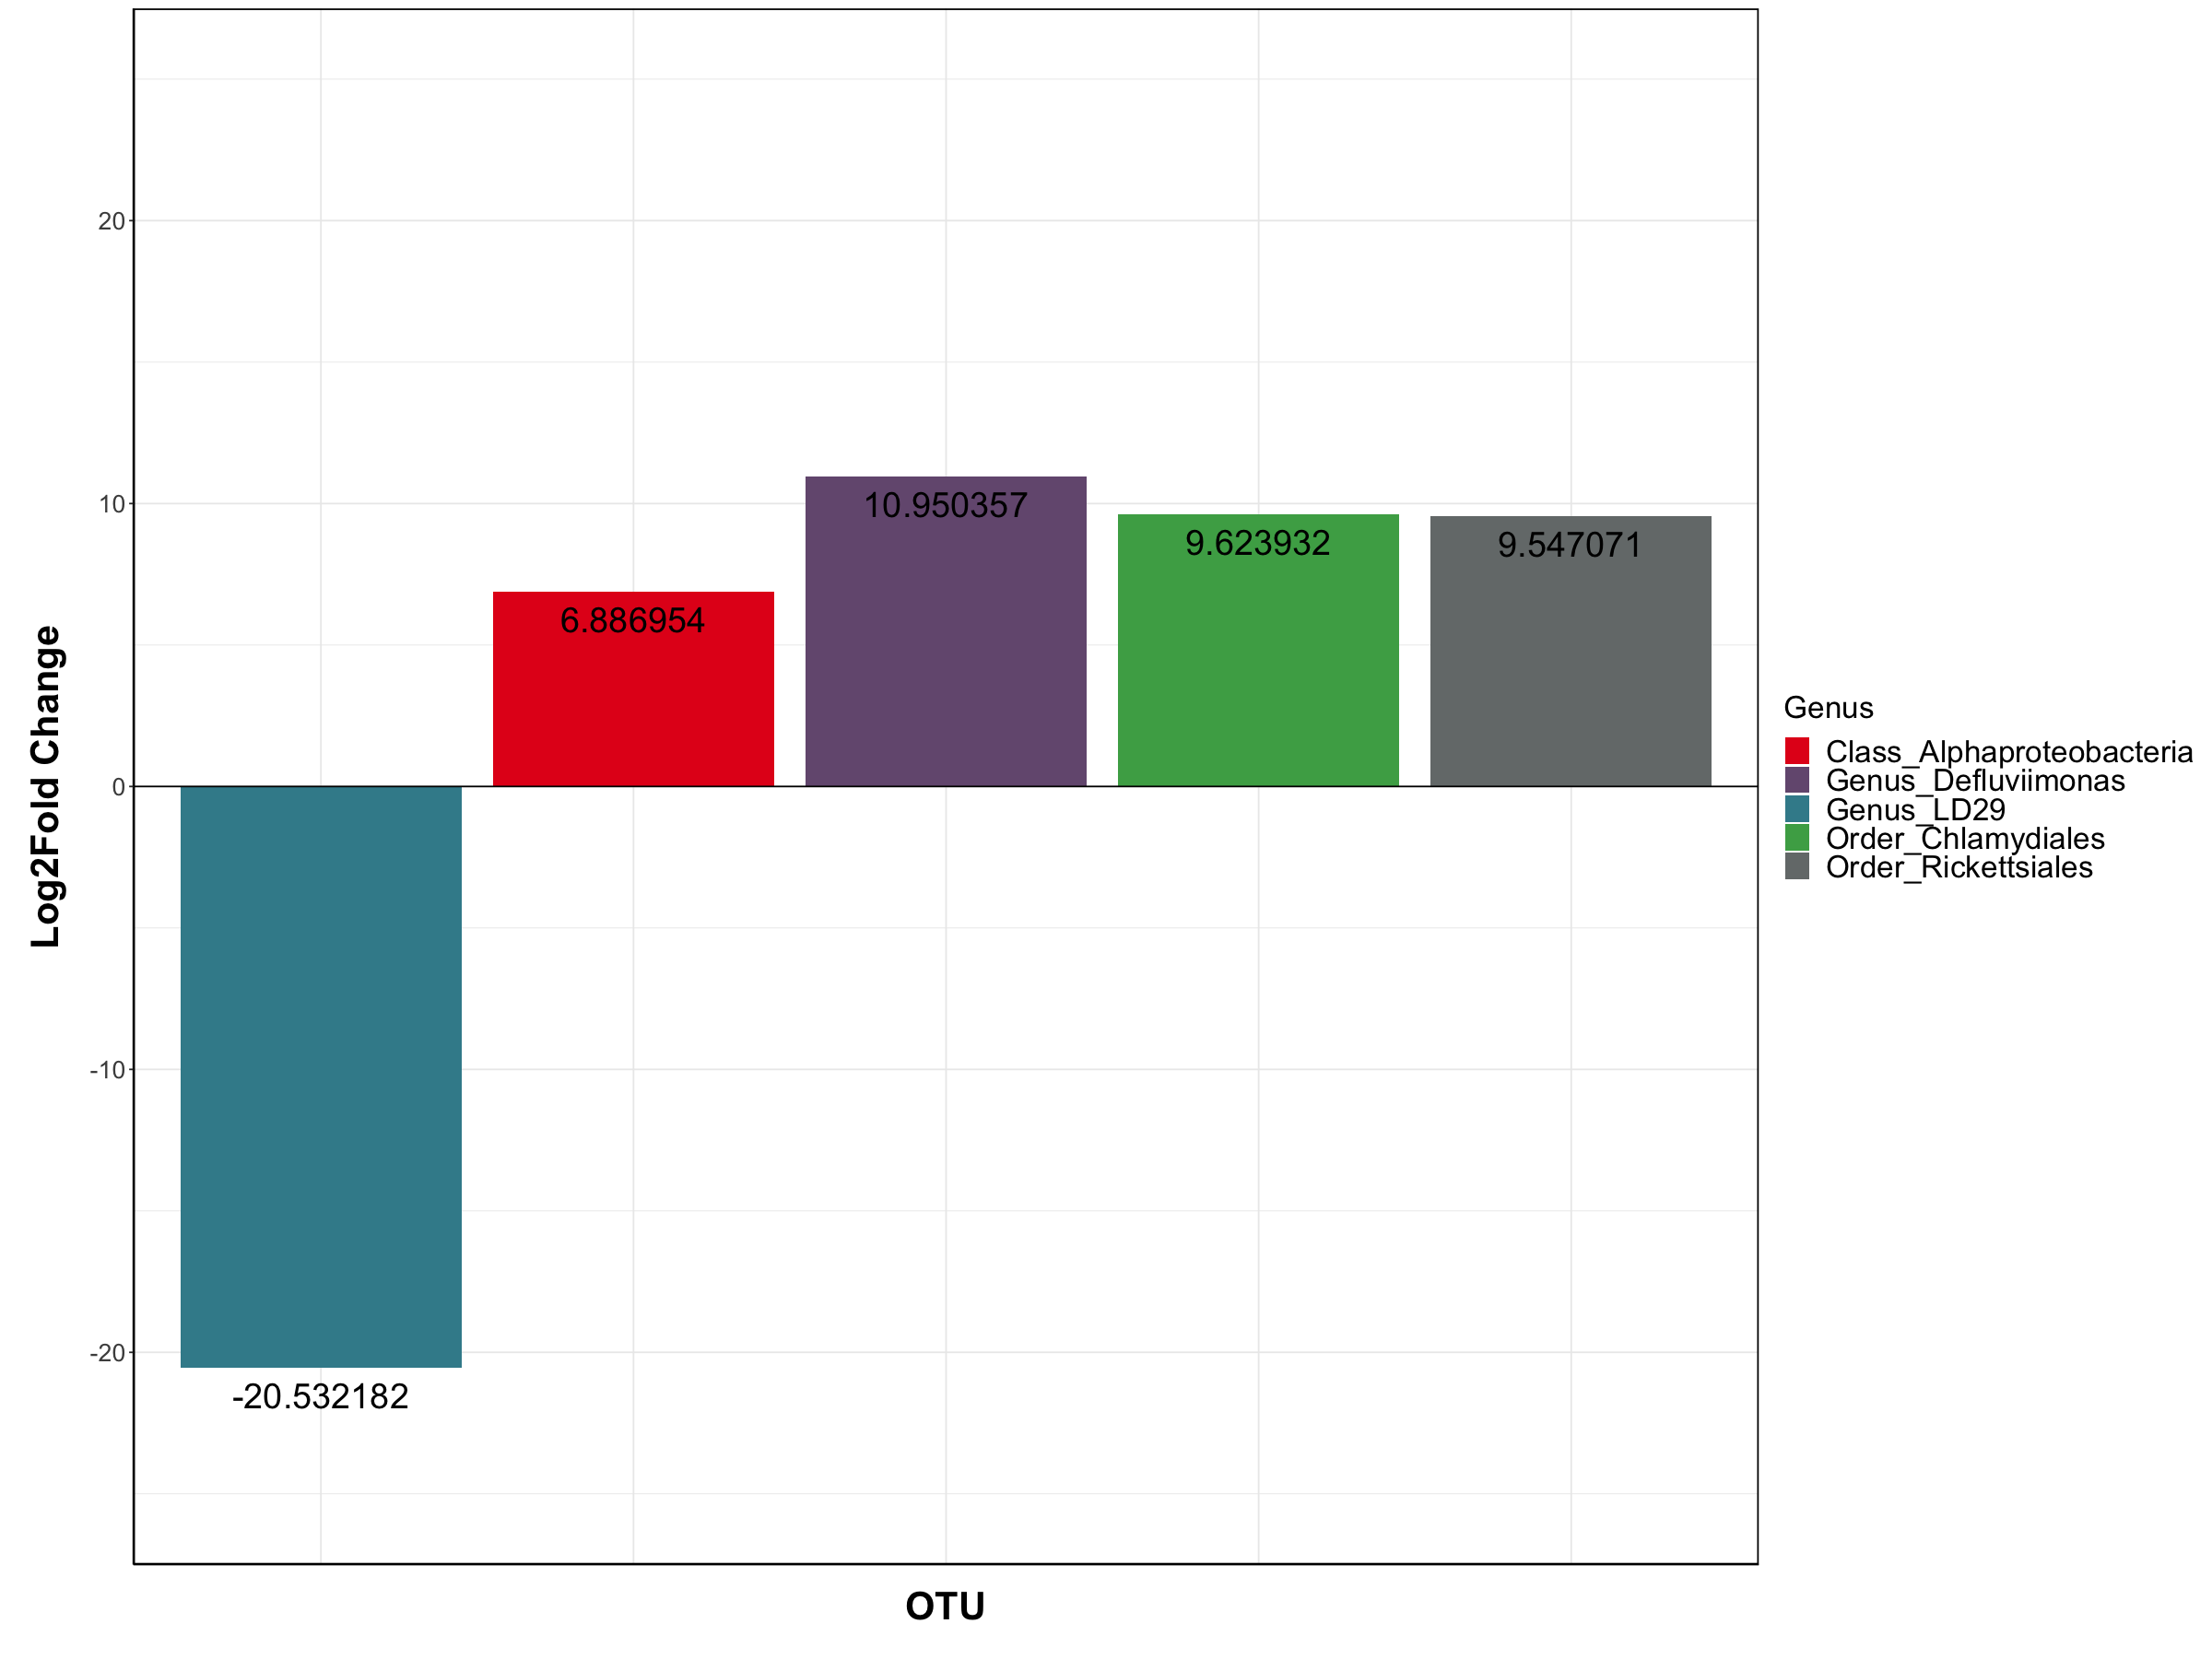

In [606]:
mycolors= colorRampPalette(brewer.pal(8, "Set1"))(12)

ggplot(vol18IR_df,aes(x = OTU, y=log2FoldChange, fill = Genus)) +
  geom_bar(stat="identity")+
geom_col(width = 0.05)+
  #scale_fill_brewer(palette="Dark2")+
  geom_text(aes(label=log2FoldChange), vjust=1.6, color="black",
            position = position_dodge(0.9), size=8)+
scale_fill_manual(values = mycolors)+
  scale_y_continuous(limits = c(-25, 25))+
  geom_hline(yintercept = 0)+
theme_bw()+
  theme(legend.position="right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.text=element_text(size=20),
        axis.line = element_line(color="black"), text = element_text(size=20), 
        axis.title.x = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)),
        axis.title.y = element_text(face = "bold", size = 25, margin=margin(15, 15, 15, 15)), 
        panel.border = element_rect(color = "black",fill = NA,size = 1))+
  labs(x = "OTU",
       y = "Log2Fold Change")

In [520]:
ggsave(file="~/Documents/DE/Figures/IRvol_bar.pdf", width = 15, height=10)

In [607]:
vol18IR_df$IR18vol=vol18IR_df$log2FoldChange
vol18IR_df$log2FoldChange=NULL

In [608]:
vol18IR_df

Kingdom         
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Kingdom_Bacteria
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Kingdom_Bacteria
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG Kingdom_Bacteria
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG Kingdom_Bacteria
                                                                                                                                                                                                                                                              Phylum                  
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Phylum_Verrucomicrobiota
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Phylum_Verrucomicrobiota
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCTGGACTAGAGTTAAGTAGAGGATAGTAGAATTCCTAATGTAGAGGTGAAATTCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGGCTGTCTGGGCTTATACTGACGCTGAGATACGAAGGTGTAGGGAGCAAACAGG Phylum_Proteobacteria   
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACTGGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTCAAAACTATCAGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG Phylum_Proteobacteria   
TACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGTGGATCGTTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCCTGGAATTGCCTTTGATACTGATGATCTGGAGTCCGGGAGAGGTGAGCGGAATTCCTAGTGTAGAGGTGATATTCGTAGATATTAGGAGGAACACCGGTGGCGAAAGCGGCTCACTGGCCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG Phylum_Proteobacteria   
                                                                                                                                                                                                                                                              Class                    
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTTCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG Class_Chlamydiae         
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGTGGCGATGCAAGTCGGGTGTGAAATCTCCAAGCTCAACTTGGAAACTGCACTCGATACTGCGTTGCTAGAGGACTGTAGAGGGCATTGGAATTCACGGTGTAGCAGTGATATGCGTAGATATCGTGAGGAAGACCAGTGGCGAAGGCGAATGCCTGGGCAGTTCCTGACACTGAGGCACGAAGGCCAGGGGAGCGAACGGG Class_Verrucomicrobiae   
TACGGGGGGGACGAGCGTTGTTCGGATTTACTGGGCGTAAAGCGTATGTAGGCGGCTCAGCAAGTTAGAAGTGAAATCCCAGGTCTTAAACCTGGAACTGCTTTTAAAACTGCT

In [609]:
CV18=merge(weight18CV_df, vol18CV_df, all=TRUE)

In [610]:
IR18=merge(weight18IR_df, vol18IR_df, all=TRUE)

In [611]:
parasite=merge(PALog, PeaLog, all=TRUE)

In [612]:
CV17=merge(parasite, CV17vol_log, all=TRUE)

In [613]:
CV=merge(CV17, CV18, all=TRUE)

In [614]:
all=merge(CV, IR18, all=TRUE)

In [615]:
all

Kingdom          Phylum                   Class                    
1  Bacteria         Phylum_Actinobacteriota  Class_Actinobacteria     
2  Bacteria         Phylum_Cyanobacteria     Class_Cyanobacteriia     
3  Bacteria         Phylum_Cyanobacteria     Class_Cyanobacteriia     
4  Bacteria         Phylum_Planctomycetota   Class_Phycisphaerae      
5  Bacteria         Phylum_Planctomycetota   Class_Planctomycetes     
6  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
7  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
8  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
9  Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
10 Bacteria         Phylum_Proteobacteria    Class_Alphaproteobacteria
11 Bacteria         Phylum_Spirochaetota     Class_Spirochaetia       
12 Bacteria         Phylum_Verrucomicrobiota Class_Chlamydiae         
13 Bacteria         Phylum_Verrucomicrobiota Class_Verrucomicrobiae   
14 Bacteria         Phylum_Verrucomicrobiota Class_Verrucomicrobiae   
15 Bacteria         Proteobacteria           Gammaproteobacteria      
16 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
17 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
18 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
19 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
20 Kingdom_Bacteria Phylum_Bacteroidota      Class_Bacteroidia        
21 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
22 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
23 Kingdom_Bacteria Phylum_Campilobacterota  Class_Campylobacteria    
24 Kingdom_Bacteria Phylum_Desulfobacterota  Class_Desulfobacteria    
25 Kingdom_Bacteria Phylum_Desulfobacterota  Class_Desulfuromonadia   
26 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
27 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
28 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
29 Kingdom_Bacteria Phylum_Firmicutes        Class_Bacilli            
30 Kingdom_Bacteria Phylum_Fusobacteriota    Class_Fusobacteriia      
31 Kingdom_Bacteria Phylum_Fusobacteriota    Class_Fusobacteriia      
32 Kingdom_Bacteria Phylum_Margulisbacteria  Phylum_Margulisbacteria  
33 Kingdom_Bacteria Phylum_Nitrospirota      Class_Nitrospiria        
34 Kingdom_Bacteria Phylum_Nitrospirota      Class_Nitrospiria        
35 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
36 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
37 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
38 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
39 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
40 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
41 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
42 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
43 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
44 Kingdom_Bacteria Phylum_Proteobacteria    Class_Alphaproteobacteria
45 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
46 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
47 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
48 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
49 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
50 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
51 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
52 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
53 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
54 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
55 Kingdom_Bacteria Phylum_Proteobacteria    Class_Gammaproteobacteria
56 Kingdom_Bacteria Phylum_

In [616]:
write.csv(all, file="~/Documents/DE/Figures/AllsigASVs.csv")